# 5243 Final Project: Stage 1
MuQing Wen, Jingyu Hu

In [7]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
import time
import os
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [8]:
# Download historical data
data0 = yf.download('BTC-USD', start="2022-01-01", end="2025-05-01")

[*********************100%***********************]  1 of 1 completed


In [9]:
print(data0.shape)

(1216, 5)


In [10]:
data0.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [11]:
# Loop through unique tickers
for ticker in data0.columns.get_level_values(1).unique():
    # Select only the columns for this ticker
    df_ticker = data0.xs(key=ticker, axis=1, level='Ticker')

    # Save to CSV using ticker name
    df_ticker.to_csv(f"{ticker}.csv")

In [12]:
df0 = pd.read_csv("BTC-USD.csv", parse_dates=True, index_col=0)
df0

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859
...,...,...,...,...,...
2025-04-26,94646.929688,95251.359375,93927.250000,94714.648438,17612825123
2025-04-27,93754.843750,95301.203125,93665.398438,94660.906250,18090367764
2025-04-28,94978.750000,95598.492188,92860.804688,93755.304688,32363449569


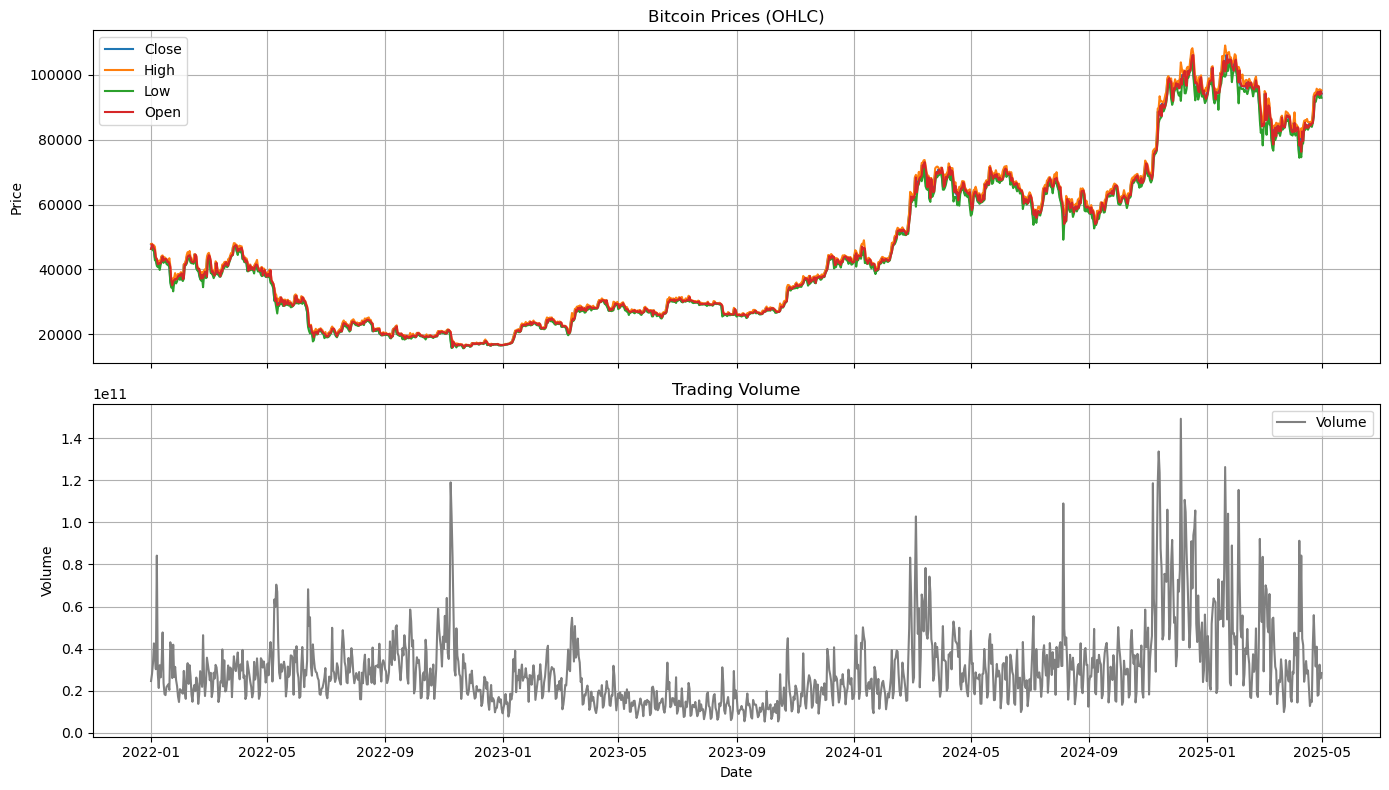

In [14]:
import matplotlib.pyplot as plt

def plot_stock_data(df, title):
    """
    Plots OHLC data and Volume data from a stock DataFrame.

    Parameters:
    - df (pd.DataFrame): A DataFrame with columns ["Close", "High", "Low", "Open", "Volume"]
                         and datetime index.
    """
    fig, ax1 = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot Close, High, Low, Open
    ax1[0].plot(df.index, df["Close"], label="Close")
    ax1[0].plot(df.index, df["High"], label="High")
    ax1[0].plot(df.index, df["Low"], label="Low")
    ax1[0].plot(df.index, df["Open"], label="Open")
    ax1[0].set_ylabel("Price")
    ax1[0].set_title(title)
    ax1[0].legend()
    ax1[0].grid(True)

    # Plot Volume
    ax1[1].plot(df.index, df["Volume"], color='gray', label="Volume")
    ax1[1].set_ylabel("Volume")
    ax1[1].set_title("Trading Volume")
    ax1[1].legend()
    ax1[1].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()

plot_stock_data(df0, "Bitcoin Prices (OHLC)")

In [15]:
import pandas as pd
import numpy as np

# Simulate a small DataFrame similar to the image structure
# (Assume the full dataset is already loaded as 'df')

# Check for NaN and Inf counts before any replacement
def check_nan_inf(df):
    nan_counts = df.isna().sum()
    inf_counts = ((df == np.inf) | (df == -np.inf)).sum()
    return nan_counts, inf_counts

nan_counts, inf_counts = check_nan_inf(df0)

nan_counts, inf_counts

(Close     0
 High      0
 Low       0
 Open      0
 Volume    0
 dtype: int64,
 Close     0
 High      0
 Low       0
 Open      0
 Volume    0
 dtype: int64)

## Compute Technical Indicators

In [16]:
def add_daily_returns(df):
    df["Daily_Return"] = df["Price"].pct_change()
    return df

In [17]:
def add_std(df, n=20):
    df[f"STD_{n}"] = df["Price"].rolling(window=n).std()
    return df

In [18]:
def add_sma(df, n=20):
    df[f"SMA_{n}"] = df["Price"].rolling(window=n).mean()
    return df

In [19]:
def add_ema(df, n=20):
    df[f"EMA_{n}"] = df["Price"].ewm(span=n, adjust=False).mean()
    return df

In [20]:
def add_bollinger_band(df, n=20):
    sma = df['Price'].rolling(window=n).mean()
    rolling_std = df['Price'].rolling(window=n).std()
    df[f"Upper_Band_{n}"] = sma + 2 * rolling_std
    df[f"Lower_Band_{n}"] = sma - 2 * rolling_std
    return df

In [21]:
def add_high_low(df, n=20):
    df[f"High_{n}"] = df['Price'].rolling(window=n).max()
    df[f"Low_{n}"] = df['Price'].rolling(window=n).min()
    return df

In [22]:
def add_rsi(df, period=14):
    delta = df["Price"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df[f"RSI_{period}"] = 100 - (100 / (1 + rs))
    return df

In [23]:
def add_ppo(df, fast=12, slow=26):
    ema_fast = df["Price"].ewm(span=fast, adjust=False).mean()
    ema_slow = df["Price"].ewm(span=slow, adjust=False).mean()
    df["PPO"] = 100 * (ema_fast - ema_slow) / ema_slow
    return df

In [24]:
def add_ppo_signal(df, signal_period=9):
    if "PPO" not in df.columns:
        df = add_ppo(df)
    df["PPO_Signal"] = df["PPO"].ewm(span=signal_period, adjust=False).mean()
    return df

In [25]:
def add_ppo_histogram(df):
    if "PPO" not in df.columns:
        df = add_ppo(df)
    if "PPO_Signal" not in df.columns:
        df = add_ppo_signal(df)
    df["PPO_Histogram"] = df["PPO"] - df["PPO_Signal"]
    return df

In [26]:
def add_macd(df, fast=12, slow=26, signal=9):
    ema_fast = df["Price"].ewm(span=fast, adjust=False).mean()
    ema_slow = df["Price"].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    df["MACD"] = macd
    df["MACD_Signal"] = signal_line
    df["MACD_Histogram"] = macd - signal_line
    return df

In [27]:
def add_sharpe_ratio(df, window=30, risk_free_rate=0.0):
    daily_returns = df["Price"].pct_change()
    excess_returns = daily_returns - risk_free_rate / 252
    rolling_mean = excess_returns.rolling(window=window).mean()
    rolling_std = excess_returns.rolling(window=window).std()
    df[f"Sharpe_{window}"] = (rolling_mean / rolling_std) * (252 ** 0.5)
    return df

In [28]:
df0.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [30]:
df0.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
               '2025-04-25', '2025-04-26', '2025-04-27', '2025-04-28',
               '2025-04-29', '2025-04-30'],
              dtype='datetime64[ns]', name='Date', length=1216, freq=None)

In [39]:
df1 = df0[['Close']].copy()
df1.columns = ['Price']
df1.columns

Index(['Price'], dtype='object')

In [40]:
df1.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
               '2025-04-25', '2025-04-26', '2025-04-27', '2025-04-28',
               '2025-04-29', '2025-04-30'],
              dtype='datetime64[ns]', name='Date', length=1216, freq=None)

In [41]:
df2 = df1.reset_index()
df2.head()

,Date,Price
0,2022-01-01,47686.812500
1,2022-01-02,47345.218750
2,2022-01-03,46458.117188
3,2022-01-04,45897.574219
4,2022-01-05,43569.003906


In [42]:
df = add_sma(df2, n=5)
df = add_sma(df, n=20)
df = add_ema(df, n=5)
df = add_ema(df, n=20)
df = add_bollinger_band(df, n=20)
df = add_high_low(df, n=20)

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_columns_against_date(df, title):
    """
    Plot all columns in the DataFrame (except 'Date') against the 'Date' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'Date' column and one or more numeric columns to plot.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' as index
    df_plot = df.set_index('Date')

    # Plot each column
    plt.figure(figsize=(12, 6))
    for column in df_plot.columns:
        plt.plot(df_plot.index, df_plot[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()

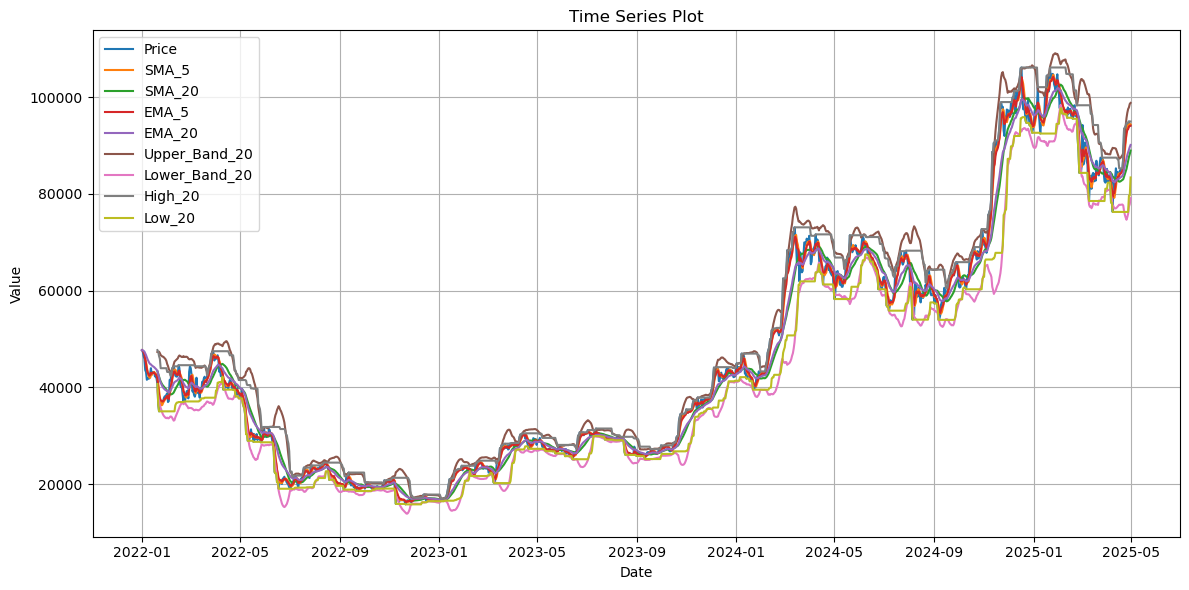

In [45]:
plot_columns_against_date(df, "Plot_Technical_Indicators")

In [46]:
nan_index = df[df.isna().any(axis=1)].index

# Display as a list of dates
nan_list = nan_index.to_list()

print(nan_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [47]:
# Drop those rows
df = df.drop(index=nan_index)

# Optionally, reset index if needed
df = df.reset_index(drop=True)

In [48]:
window_size = 14
start = 0
end = start + window_size

split = int(0.8 * window_size)

window_data = df.iloc[start:end]
window_data.shape

(14, 10)

## Sliding Window Forcast

In [49]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def sliding_window_forecast(df, model_class, window_size=14, model_params=None):
    if model_params is None:
        model_params = {}

    results = []

    # Shift the target: predict next day's price using current features
    df["Target"] = df["Price"].shift(-1)

    # Drop the last row (Target is NaN)
    df = df.dropna()

    # Feature columns (exclude 'Date' and 'Target')
    feature_cols = [col for col in df.columns if col not in ['Date', 'Target']]

    for start in range(0, len(df) - window_size + 1):
        end = start + window_size
        window = df.iloc[start:end].copy()

        train_data = window.iloc[:-1]  # All except the last row
        test_data = window.iloc[-1:]   # Only the last row

        model = model_class(**model_params)
        model.fit(train_data[feature_cols], train_data["Target"])
        predictions = model.predict(test_data[feature_cols])
        # print(test_data["Target"].values, predictions)

        temp_result = pd.DataFrame({
            "Date": test_data["Date"].values,
            "Price": test_data["Price"].values,
            "Actual": test_data["Target"].values,
            "Predicted": predictions
        })

        results.append(temp_result)

    final_results = pd.concat(results, ignore_index=True)
    return final_results

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

results = sliding_window_forecast(df, model_class=lambda: XGBRegressor(
        n_estimators=100, max_depth=4, subsample=0.8,
        colsample_bytree=0.8, learning_rate=0.1, verbosity=0, random_state=42), window_size=14)

In [57]:
display(results)

,Date,Price,Actual,Predicted
0,2022-02-02,36952.984375,37154.601562,37742.910156
1,2022-02-03,37154.601562,41500.875000,38244.015625
2,2022-02-04,41500.875000,41441.164062,40391.117188
3,2022-02-05,41441.164062,42412.433594,41212.730469
4,2022-02-06,42412.433594,43840.285156,42238.457031
...,...,...,...,...
1178,2025-04-25,94720.500000,94646.929688,94653.515625
1179,2025-04-26,94646.929688,93754.843750,94676.882812
1180,2025-04-27,93754.843750,94978.750000,93821.671875
1181,2025-04-28,94978.750000,94284.789062,94613.507812


In [58]:
from sklearn.metrics import mean_squared_error, r2_score

test_r2 = r2_score(results['Actual'], results['Predicted'])

In [59]:
test_r2

0.995540954306834

In [60]:
import matplotlib.pyplot as plt

def plot_actual_vs_prediction(df, title="Actual vs Predicted Values"):
    """
    Plots the actual and predicted values over time.

    Parameters:
    - df: pandas DataFrame with columns ['Date', 'Actual', 'Predicted']
    - title: title of the plot (optional)
    """
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Actual'], label='Actual', linewidth=2)
    plt.plot(df['Date'], df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()

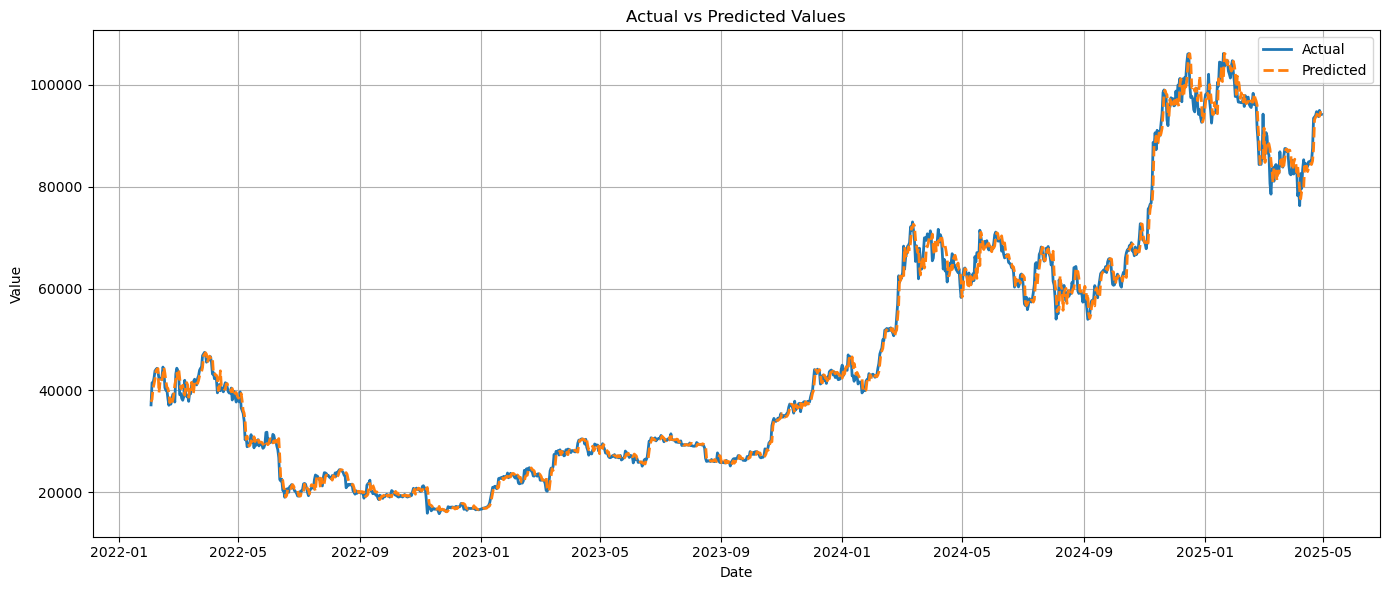

In [61]:
# Assuming your DataFrame is named result_df
plot_actual_vs_prediction(results)

In [62]:
def analyze_results(df):
    total_days = len(df)

    # Ratio 1: Actual > Price
    actual_gt_price = (df['Actual'] > df['Price']).sum()
    ratio1 = actual_gt_price / total_days

    # Count where Actual > Price and Predicted > Price
    actual_gt_price = (df['Actual'] > df['Price']).sum()
    predicted_gt_price = (df['Predicted'] > df['Price']).sum()

    # Ratio 2: Actual > Price / Predicted > Price
    if predicted_gt_price == 0:
        ratio2 = float('inf')  # or np.nan, depending on preference
    else:
        ratio2 = actual_gt_price / predicted_gt_price

    # Return as a table
    result_df = pd.DataFrame({
        'Actual > Price (%)': [round(ratio1 * 100, 2)],
        'Actual > Price / Predicted > Price': [round(ratio2, 2)]
    })

    return result_df

In [63]:
result_2 = analyze_results(results)
display(result_2)

,Actual > Price (%),Actual > Price / Predicted > Price
0,49.54,1.02


In [64]:
df.head()

,Date,Price,SMA_5,SMA_20,EMA_5,EMA_20,Upper_Band_20,Lower_Band_20,High_20,Low_20,Target
0,2022-01-20,40680.417969,42032.961719,43343.039844,41791.158671,43353.489207,47304.826020,39381.253668,47686.812500,40680.417969,36457.316406
1,2022-01-21,36457.316406,40701.649219,42781.565039,40013.211250,42696.710845,47295.742900,38267.387179,47345.218750,36457.316406,35030.250000
2,2022-01-22,35030.250000,39257.589063,42165.816602,38352.224166,41966.571717,47366.374977,36965.258226,46458.117188,35030.250000,36276.804688
3,2022-01-23,36276.804688,38037.823438,41656.750977,37660.417673,41424.689143,47076.815960,36236.685993,45897.574219,35030.250000,36654.328125
4,2022-01-24,36654.328125,37019.823438,41194.588672,37325.054491,40970.369046,46668.142674,35721.034670,43949.101562,35030.250000,36954.003906


In [65]:
df.iloc[0]['Price']

40680.41796875

In [66]:
results.head()

,Date,Price,Actual,Predicted
0,2022-02-02,36952.984375,37154.601562,37742.910156
1,2022-02-03,37154.601562,41500.875000,38244.015625
2,2022-02-04,41500.875000,41441.164062,40391.117188
3,2022-02-05,41441.164062,42412.433594,41212.730469
4,2022-02-06,42412.433594,43840.285156,42238.457031


## Compute Signals (For Portfolio / Q-Table State)

In [67]:
def add_sma_crossover_signal(df, short=5, long=20):
    """
    Adds a 'SMA_crossover' column to the DataFrame:
    - 1 when SMA_5 crosses above SMA_20 (golden cross)
    - -1 when SMA_5 crosses below SMA_20 (death cross)
    - 0 otherwise

    Parameters:
    - df: pandas DataFrame with columns ['SMA_5', 'SMA_20']

    Returns:
    - df with an added 'SMA_crossover' column
    """
    df = df.copy()
    df['SMA_crossover'] = 0

    # Previous values
    prev_sma5 = df[f'SMA_{short}'].shift(1)
    prev_sma20 = df[f'SMA_{long}'].shift(1)

    # Golden cross condition
    golden_cross = (prev_sma5 < prev_sma20) & (df[f'SMA_{short}'] >= df[f'SMA_{long}'])

    # Death cross condition
    death_cross = (prev_sma5 > prev_sma20) & (df[f'SMA_{short}'] <= df[f'SMA_{long}'])

    df.loc[golden_cross, 'SMA_crossover'] = 1
    df.loc[death_cross, 'SMA_crossover'] = -1

    return df

In [68]:
def add_high_low_breakout_signal(df, n=20):
    """
    Adds a 'high_low_crossover' column to the DataFrame:
    - 1 when 'Price' is above 'High_{n}'
    - -1 when 'Price' is below 'Low_{n}'
    - 0 otherwise

    Parameters:
    - df: pandas DataFrame with 'Price', 'High_{n}', and 'Low_{n}'
    - n: integer window size (default=20)

    Returns:
    - DataFrame with 'high_low_crossover' column
    """
    df = df.copy()
    high_col = f'High_{n}'
    low_col = f'Low_{n}'
    
    df['high_low_breakout'] = 0
    df.loc[df['Price'] > df[high_col], 'high_low_breakout'] = 1
    df.loc[df['Price'] < df[low_col], 'high_low_breakout'] = -1

    return df

In [69]:
def add_bollinger_breakout_signal(df, n=20):
    """
    Adds a 'bollinger_crossover' column to the DataFrame:
    - 1 when 'Price' is above 'Upper_Band_{n}'
    - -1 when 'Price' is below 'Lower_Band_{n}'
    - 0 otherwise

    Parameters:
    - df: pandas DataFrame with 'Price', 'Upper_Band_{n}', and 'Lower_Band_{n}'
    - n: integer window size (default=20)

    Returns:
    - DataFrame with 'bollinger_crossover' column
    """
    df = df.copy()
    upper_col = f'Upper_Band_{n}'
    lower_col = f'Lower_Band_{n}'

    df['bollinger_breakout'] = 0
    df.loc[df['Price'] > df[upper_col], 'bollinger_breakout'] = 1
    df.loc[df['Price'] < df[lower_col], 'bollinger_breakout'] = -1

    return df

In [70]:
def add_predicted_price_change_direction(df, results):
    """
    Adds a 'predicted_price_change_signal' column to df:
    - 1 if Predicted > Price
    - -1 if Predicted < Price
    - 0 otherwise or if date not in results

    Parameters:
    - df: DataFrame with columns ['Date', 'Price']
    - results: DataFrame with columns ['Date', 'Predicted']

    Returns:
    - df with 'predicted_price_change_signal' column
    """
    df = df.copy()
    df['predicted_price_change_direction'] = 0

    # Find the starting index in df that matches first date in results
    start_date = results.iloc[0]['Date']
    try:
        start_idx = df[df['Date'] == start_date].index[0]
    except IndexError:
        raise ValueError(f"Start date '{start_date}' from results not found in df.")

    # Limit df and results to aligned matching range
    end_idx = start_idx + len(results)
    aligned_df = df.iloc[start_idx:end_idx].copy()
    
    # Ensure alignment
    if not (aligned_df['Date'].reset_index(drop=True).equals(results['Date'].reset_index(drop=True))):
        raise ValueError("Dates after alignment do not match between df and results.")

    # Compare predicted and actual price
    comparison = results['Predicted'].values > aligned_df['Price'].values
    signal = [1 if p > pr else -1 if p < pr else 0
              for p, pr in zip(results['Predicted'].values, aligned_df['Price'].values)]

    # Assign the signal
    df.loc[start_idx:end_idx-1, 'predicted_price_change_direction'] = signal

    return df

In [71]:
df3 = add_predicted_price_change_direction(df, results)
df3.iloc[0:20]

,Date,Price,SMA_5,SMA_20,EMA_5,EMA_20,Upper_Band_20,Lower_Band_20,High_20,Low_20,Target,predicted_price_change_direction
0,2022-01-20,40680.417969,42032.961719,43343.039844,41791.158671,43353.489207,47304.826020,39381.253668,47686.812500,40680.417969,36457.316406,0
1,2022-01-21,36457.316406,40701.649219,42781.565039,40013.211250,42696.710845,47295.742900,38267.387179,47345.218750,36457.316406,35030.250000,0
2,2022-01-22,35030.250000,39257.589063,42165.816602,38352.224166,41966.571717,47366.374977,36965.258226,46458.117188,35030.250000,36276.804688,0
3,2022-01-23,36276.804688,38037.823438,41656.750977,37660.417673,41424.689143,47076.815960,36236.685993,45897.574219,35030.250000,36654.328125,0
4,2022-01-24,36654.328125,37019.823438,41194.588672,37325.054491,40970.369046,46668.142674,35721.034670,43949.101562,35030.250000,36954.003906,0
5,2022-01-25,36954.003906,36274.540625,40863.838672,37201.370963,40587.858080,46529.354283,35198.323061,43949.101562,35030.250000,36852.121094,0
6,2022-01-26,36852.121094,36353.501563,40548.398242,37084.954340,40232.073605,46375.612371,34721.184113,43949.101562,35030.250000,37138.234375,0
7,2022-01-27,37138.234375,36775.098437,40327.414844,37102.714351,39937.422250,46326.124569,34328.705119,43949.101562,35030.250000,37784.332031,0
8,2022-01-28,37784.332031,37076.603906,40129.934375,37329.920245,39732.366039,46193.378676,34066.490074,43949.101562,35030.250000,38138.179688,0
9,2022-01-29,38138.179688,37373.374219,39941.263281,37599.340059,39580.538767,46006.110359,33876.416203,43949.101562,35030.250000,37917.601562,0


## Define Portfolio

In [181]:
class Portfolio:
    def __init__(
        self, 
        price_df, 
        transaction_cost=0.01, 
        max_repeat=5, 
        initial_cash=10000.0, 
        initial_inventory=0.0, 
        transaction_size=0.10
    ):
        self.price_df = price_df
        self.transaction_cost = transaction_cost
        self.max_repeat = max_repeat
        self.initial_cash = initial_cash
        self.initial_inventory = initial_inventory
        self.transaction_size = transaction_size
        self.reset()

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_cash
        self.inventory = self.initial_inventory
        self.action_repeat_count = {'buy': 0, 'hold': 0, 'sell': 0}

    def get_curr_price(self):
        return self.price_df.iloc[self.current_step]['Price']

    def get_sma_crossover(self):
        if 'SMA_crossover' not in self.price_df.columns:
            self.price_df = add_sma_crossover_signal(self.price_df)
        return self.price_df.iloc[self.current_step]['SMA_crossover']

    def get_bollinger_band_breakout(self):
        if 'bollinger_breakout' not in self.price_df.columns:
            self.price_df = add_bollinger_breakout_signal(self.price_df)
        return self.price_df.iloc[self.current_step]['bollinger_breakout']

    def get_high_low_breakout(self):
        if 'high_low_breakout' not in self.price_df.columns:
            self.price_df = add_high_low_breakout_signal(self.price_df)
        return self.price_df.iloc[self.current_step]['high_low_breakout']

    def get_price_change_direction(self):
        return self.price_df.iloc[self.current_step]['predicted_price_change_direction']

    def get_state(self):
        signal_1 = self.get_price_change_direction()
        signal_2 = self.get_sma_crossover()
        signal_3 = self.get_high_low_breakout()
        signal_4 = self.get_bollinger_band_breakout()
        return (signal_1, signal_2, signal_3, signal_4)

    def compute_portfolio_value(self):
        current_price = self.get_curr_price()
        return self.cash + self.inventory * current_price

    def buy(self, price):
        amount_to_spend = self.cash * self.transaction_size
        if amount_to_spend > 1e-8:
            btc_bought = (amount_to_spend * (1 - self.transaction_cost)) / price
            self.inventory += btc_bought
            self.cash -= amount_to_spend

    def sell(self, price):
        amount_to_sell = self.inventory * self.transaction_size
        if amount_to_sell > 1e-8:
            proceeds = amount_to_sell * price * (1 - self.transaction_cost)
            self.inventory -= amount_to_sell
            self.cash += proceeds

    def take_action(self, action):
        price = self.get_curr_price()

        if self.action_repeat_count[action] < self.max_repeat:
            if action == 'buy':
                self.buy(price)
            elif action == 'sell':
                self.sell(price)
            # hold = do nothing

            # Update repeat count
            for a in self.action_repeat_count:
                self.action_repeat_count[a] = (
                    self.action_repeat_count[a] + 1 if a == action else 0
                )

## Define Agent

In [182]:
import random

class Agent:
    def __init__(self, actions, epsilon=1.0, epsilon_decay=0.95, epsilon_min=0.01):
        """
        Initializes the agent with action space and exploration strategy.

        Parameters:
        - actions: list of available actions (e.g., ['buy', 'hold', 'sell'])
        - epsilon: initial exploration rate
        - epsilon_decay: how fast epsilon decays per episode
        - epsilon_min: minimum epsilon value to maintain some exploration
        """
        self.actions = actions
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def action_group(self, action):
        if 'buy' in action:
            return 'buy'
        elif 'sell' in action:
            return 'sell'
        return 'hold'


    def get_action(self, state, q_table, action_repeat_count, max_repeat):
        """
        Chooses an action using ε-greedy policy, constrained by max_repeat rule.

        Parameters:
        - state: current signal tuple (e.g., (1, 0, -1, 1))
        - q_table: reference to Q_table instance
        - action_repeat_count: dictionary of recent action repetition counts
        - max_repeat: max allowed consecutive repetitions for any action

        Returns:
        - action: selected action string
        """
        # Filter out actions that exceeded repeat limit
        valid_actions = [a for a in self.actions if action_repeat_count.get(self.action_group(a), 0) < max_repeat]
        # valid_actions = [a for a in self.actions if action_repeat_count.get(a, 0) < max_repeat]
        if not valid_actions:
            return 'hold'  # fallback

        # Exploration vs. exploitation
        if random.random() < self.epsilon:
            random_action = random.choice(valid_actions)
            # print(f"random choice: {random_action} (self.epsilon={self.epsilon})")
            return random_action
        else:
            q_values = q_table.q_table.loc[state]
            # Restrict to valid actions
            best_action = max(valid_actions, key=lambda a: q_values[a])
            return best_action

    def decay_epsilon(self):
        """Decays the epsilon value after each episode."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [183]:
from itertools import product

signal_values = [-1, 0, 1]
num_signals = 4

state_space = list(product(signal_values, repeat=num_signals))
state_space[:10]

[(-1, -1, -1, -1),
 (-1, -1, -1, 0),
 (-1, -1, -1, 1),
 (-1, -1, 0, -1),
 (-1, -1, 0, 0),
 (-1, -1, 0, 1),
 (-1, -1, 1, -1),
 (-1, -1, 1, 0),
 (-1, -1, 1, 1),
 (-1, 0, -1, -1)]

## Define Q-Table

In [184]:
import numpy as np
import pandas as pd
from itertools import product

class Q_table:
    def __init__(self, actions, num_signals):
        """
        Initializes the Q-table as a pandas DataFrame.

        Parameters:
        - actions: list of possible actions (e.g., ['buy', 'hold', 'sell'])
        - num_signals: number of signals, each taking values -1, 0, 1
        """
        self.actions = actions
        self.num_signals = num_signals
        self.signal_values = [-1, 0, 1]

        # Generate all possible signal combinations (tuples)
        self.permutations = list(product(self.signal_values, repeat=self.num_signals))

        # Map: permutation ↔ index (optional, for fast lookup)
        self.state_to_index = {p: i for i, p in enumerate(self.permutations)}
        self.index_to_state = {i: p for i, p in enumerate(self.permutations)}

        # Create the Q-table as a DataFrame with signal tuples as index
        index = pd.MultiIndex.from_tuples(
            self.permutations,
            names=[f'signal_{i+1}' for i in range(self.num_signals)]
        )

        self.q_table = pd.DataFrame(
            data=0.0,
            index=index,
            columns=self.actions
        )

    def get_state(self, signal_perm):
        """
        Given a signal permutation (tuple or list), returns the row index in the Q-table.

        Parameters:
        - signal_perm: list or tuple of signals (length = num_signals)

        Returns:
        - Integer index of the state in the Q-table (or None if not found)
        """
        signal_tuple = tuple(signal_perm)
        return self.state_to_index.get(signal_tuple, None)

    def update(self, state, action, reward, next_state, next_action, alpha=0.1, gamma=0.9):
        """
        Performs a SARSA update on the Q-table.
    
        Parameters:
        - state: tuple, current signal permutation (e.g., (1, 0, -1, 1))
        - action: string, action taken in current state (e.g., 'buy')
        - reward: float, reward received after taking the action
        - next_state: tuple, signal permutation after taking the action
        - next_action: string, action actually taken in next_state
        - alpha: float, learning rate
        - gamma: float, discount factor
        """
        current_q = self.q_table.loc[state, action]
        next_q = self.q_table.loc[next_state, next_action]
    
        updated_q = current_q + alpha * (reward + gamma * next_q - current_q)
        self.q_table.loc[state, action] = updated_q

    def update2(self, state, action, reward, next_state, alpha=0.1, gamma=0.9):
        """
        Performs a Q-learning (off-policy) update on the Q-table.
    
        Parameters:
        - state: tuple, current signal permutation (e.g., (1, 0, -1, 1))
        - action: string, action taken in current state (e.g., 'buy')
        - reward: float, reward received after taking the action
        - next_state: tuple, signal permutation after taking the action
        - alpha: float, learning rate
        - gamma: float, discount factor
        """
        current_q = self.q_table.loc[state, action]
        max_next_q = self.q_table.loc[next_state].max()  # greedy choice in next state
    
        updated_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
        self.q_table.loc[state, action] = updated_q

In [185]:
q_table = Q_table(actions=["buy", "hold", "sell"], num_signals=4)

In [186]:
q_table.q_table

buy  hold  sell
signal_1 signal_2 signal_3 signal_4                 
-1       -1       -1       -1        0.0   0.0   0.0
                            0        0.0   0.0   0.0
                            1        0.0   0.0   0.0
                   0       -1        0.0   0.0   0.0
                            0        0.0   0.0   0.0
...                                  ...   ...   ...
 1        1        0        0        0.0   0.0   0.0
                            1        0.0   0.0   0.0
                   1       -1        0.0   0.0   0.0
                            0        0.0   0.0   0.0
                            1        0.0   0.0   0.0

[81 rows x 3 columns]

In [187]:
portfolio = Portfolio(price_df=df3)
state = portfolio.get_state()
print(state)

(0, 0, 0, 0)


## Test 1 Update of the Q-Table

In [188]:
def train(price_df):
    """
    Runs one SARSA training step: initialize, choose action, take step, update Q-table.

    Returns:
    - portfolio, q_table, agent
    """
    # Initialization
    portfolio = Portfolio(price_df)
    actions = ['buy', 'hold', 'sell']
    agent = Agent(actions)
    q_table = Q_table(actions, num_signals=4)

    # 1. Get current state
    state = portfolio.get_state()

    # 2. Choose action
    action = agent.get_action(
        state, q_table,
        portfolio.action_repeat_count,
        portfolio.max_repeat
    )

    # 3. Record portfolio value before action
    v1 = portfolio.compute_portfolio_value()

    # 4. Take the action
    portfolio.take_action(action)

    # 5. Record portfolio value after action
    v2 = portfolio.compute_portfolio_value()
    reward = v2 - v1

    # 6. Advance one day
    portfolio.current_step += 1

    # 7. Get next state
    next_state = portfolio.get_state()

    # 8. Choose next action (for SARSA)
    next_action = agent.get_action(
        next_state, q_table,
        portfolio.action_repeat_count,
        portfolio.max_repeat
    )

    # 9. Update Q-table using SARSA
    q_table.update(state, action, reward, next_state, next_action)

    return portfolio, q_table, agent

## Test 10 Updates of the Q-Table

In [189]:
def train(price_df):
    """
    Run a 10-step SARSA training loop with state/action tracking.

    Returns:
    - portfolio, q_table, agent, results (DataFrame with per-step logs)
    """
    # Initialization
    portfolio = Portfolio(price_df)
    actions = ['buy', 'hold', 'sell']
    agent = Agent(actions)
    q_table = Q_table(actions, num_signals=4)

    # Record containers
    date_log = []
    state_log = []
    action_log = []
    reward_log = []
    value_before_log = []
    value_after_log = []
    price_log = []
    cash_log = []
    inventory_log = []

    # Initial state and action
    state = portfolio.get_state()
    action = agent.get_action(
        state, q_table,
        portfolio.action_repeat_count,
        portfolio.max_repeat
    )

    for _ in range(10):
    # while portfolio.current_step < len(portfolio.price_df) - 1:
        # Log date and portfolio value before action
        date_log.append(portfolio.price_df.iloc[portfolio.current_step]['Date'])
        value_before = portfolio.compute_portfolio_value()
        value_before_log.append(value_before)
        state_log.append(state)
        action_log.append(action)
        price_log.append(portfolio.get_curr_price())
        cash_log.append(portfolio.cash)
        inventory_log.append(portfolio.inventory)

        # Take action
        portfolio.take_action(action)

        # Compute value after action
        value_after = portfolio.compute_portfolio_value()

        value_after_log.append(value_after)

        # Advance one step
        portfolio.current_step += 1

        # Compute reward the next day
        value_next = portfolio.compute_portfolio_value()
        reward = value_next - value_after
        reward_log.append(reward)

        # Get next state and next action (SARSA)
        next_state = portfolio.get_state()
        next_action = agent.get_action(
            next_state, q_table,
            portfolio.action_repeat_count,
            portfolio.max_repeat
        )

        # Q-table update
        q_table.update(state, action, reward, next_state, next_action)

        # Prepare for next iteration
        state = next_state
        action = next_action

    # Combine logs into a results DataFrame
    results = pd.DataFrame({
        "Date": date_log,
        "State": state_log,
        "Action": action_log,
        "Reward": reward_log,
        "Value_Before": value_before_log,
        "Value_After": value_after_log,
        "Price": price_log,
        "Cash": cash_log,
        "Inventory": inventory_log
    })

    return portfolio, q_table, agent, results

In [190]:
portfolio1, q_table1, agent1, results1 = train(df3)

## Display Training Result

In [191]:
results1

,Date,State,Action,Reward,Value_Before,Value_After,Price,Cash,Inventory
0,2022-01-20,"(0, 0, 0, 0)",sell,0.000000,10000.000000,10000.000000,40680.417969,10000.000000,0.000000
1,2022-01-21,"(0, 0, 0, -1)",sell,0.000000,10000.000000,10000.000000,36457.316406,10000.000000,0.000000
2,2022-01-22,"(0, 0, 0, -1)",buy,35.229242,10000.000000,9990.000000,35030.250000,10000.000000,0.000000
3,2022-01-23,"(0, 0, 0, 0)",sell,9.602369,10025.229242,10024.204012,36276.804688,9000.000000,0.028261
4,2022-01-24,"(0, 0, 0, 0)",hold,7.622301,10033.806381,10033.806381,36654.328125,9101.497695,0.025435
5,2022-01-25,"(0, 0, 0, 0)",hold,-2.591406,10041.428683,10041.428683,36954.003906,9101.497695,0.025435
6,2022-01-26,"(0, 0, 0, 0)",hold,7.277337,10038.837277,10038.837277,36852.121094,9101.497695,0.025435
7,2022-01-27,"(0, 0, 0, 0)",hold,16.433597,10046.114614,10046.114614,37138.234375,9101.497695,0.025435
8,2022-01-28,"(0, 0, 0, 0)",hold,9.000172,10062.548211,10062.548211,37784.332031,9101.497695,0.025435
9,2022-01-29,"(0, 0, 0, 0)",sell,-5.049396,10071.548383,10070.578332,38138.179688,9101.497695,0.025435


In [192]:
print("=== Portfolio Attributes ===")
for attr, value in vars(portfolio1).items():
    if attr == 'price_df':
        print(f"{attr}: DataFrame with shape {value.shape}")
        # Show only current row for context
        print(f"{attr}.iloc[current_step]:")
        print(value.iloc[portfolio1.current_step])
    else:
        print(f"{attr}: {value}")

# Print all attributes of Agent
print("\n=== Agent Attributes ===")
for attr, value in vars(agent1).items():
    print(f"{attr}: {value}")

=== Portfolio Attributes ===
price_df: DataFrame with shape (1197, 15)
price_df.iloc[current_step]:
Date                                2022-01-30 00:00:00
Price                                      37917.601562
SMA_5                                       37566.09375
SMA_20                                     39746.080273
EMA_5                                      37705.427227
EMA_20                                     39422.163795
Upper_Band_20                               45807.43573
Lower_Band_20                              33684.724817
High_20                                    43949.101562
Low_20                                         35030.25
Target                                        38483.125
predicted_price_change_direction                      0
SMA_crossover                                         0
high_low_breakout                                     0
bollinger_breakout                                    0
Name: 10, dtype: object
transaction_cost: 0.01
max_repeat: 5

In [193]:
print("\n=== Q_table: Non-zero Q-value States ===")
non_zero_q = q_table1.q_table[(q_table1.q_table != 0).any(axis=1)]
print(non_zero_q)


=== Q_table: Non-zero Q-value States ===
                                          buy     hold      sell
signal_1 signal_2 signal_3 signal_4                             
0        0        0        -1        3.522924  0.00000  0.000000
                            0        0.000000  3.55092  0.678856


In [194]:
unique_states = results1["State"].unique()
print(unique_states)

[(0, 0, 0, 0) (0, 0, 0, -1)]


In [195]:
portfolio1.compute_portfolio_value()

10065.52893606084

In [196]:
action_counts = results1["Action"].value_counts()
print(action_counts)

Action
hold    5
sell    4
buy     1
Name: count, dtype: int64


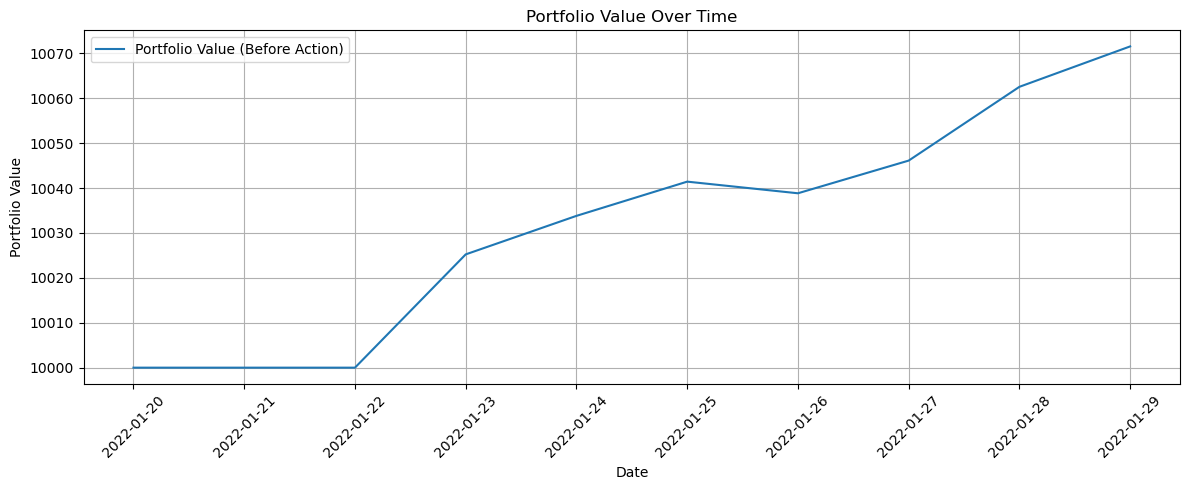

In [197]:
plt.figure(figsize=(12, 5))
plt.plot(results1["Date"], results1["Value_Before"], label="Portfolio Value (Before Action)")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Train Multiple Episodes

In [160]:
def train_multiple_episodes(price_df, episodes=2):
    """
    Run SARSA training over multiple episodes using the same price data.

    Returns:
    - q_table: trained Q_table object
    - agent: trained Agent object
    - results_dict: dictionary of {episode_number: DataFrame of logs}
    """
    actions = ['buy', 'hold', 'sell']
    agent = Agent(actions)
    q_table = Q_table(actions, num_signals=4)

    results_dict = {}

    for ep in range(1, episodes + 1):
        portfolio = Portfolio(price_df)

        # Logging containers for current episode
        date_log = []
        state_log = []
        action_log = []
        reward_log = []
        value_before_log = []
        value_after_log = []
        price_log = []
        cash_log = []
        inventory_log = []

        # Initial state and action
        state = portfolio.get_state()
        action = agent.get_action(
            state, q_table,
            portfolio.action_repeat_count,
            portfolio.max_repeat
        )

        while portfolio.current_step < len(portfolio.price_df) - 1:
            # Log before action
            date_log.append(portfolio.price_df.iloc[portfolio.current_step]['Date'])
            value_before = portfolio.compute_portfolio_value()
            value_before_log.append(value_before)
            state_log.append(state)
            action_log.append(action)
            price_log.append(portfolio.get_curr_price())
            cash_log.append(portfolio.cash)
            inventory_log.append(portfolio.inventory)

            # Take action
            portfolio.take_action(action)

            # Portfolio value after action
            value_after = portfolio.compute_portfolio_value()
            value_after_log.append(value_after)

            # Advance time
            portfolio.current_step += 1

            # Reward = next day's portfolio delta
            value_next = portfolio.compute_portfolio_value()

            reward = value_next - value_after
            
            # Penalize losses, ignore gains
            # reward = min(0, value_next - value_after)
            reward_log.append(reward)

            # Get next state and action
            next_state = portfolio.get_state()
            next_action = agent.get_action(
                next_state, q_table,
                portfolio.action_repeat_count,
                portfolio.max_repeat
            )

            # Update Q-table (SARSA)
            q_table.update(state, action, reward, next_state, next_action)

            # Prepare for next iteration
            state = next_state
            action = next_action

        # Decay exploration rate
        agent.decay_epsilon()

        # Store this episode’s results in a DataFrame
        episode_df = pd.DataFrame({
            "Date": date_log,
            "State": state_log,
            "Action": action_log,
            "Reward": reward_log,
            "Value_Before": value_before_log,
            "Value_After": value_after_log,
            "Price": price_log,
            "Cash": cash_log,
            "Inventory": inventory_log
        })

        results_dict[ep] = episode_df

    return q_table, agent, results_dict

In [161]:
q_table2, agent2, results_dict2 = train_multiple_episodes(df3, episodes=50)

In [162]:
results_dict2[1]

,Date,State,Action,Reward,Value_Before,Value_After,Price,Cash,Inventory
0,2022-01-20,"(0, 0, 0, 0)",hold,0.000000,10000.000000,10000.000000,40680.417969,10000.000000,0.000000
1,2022-01-21,"(0, 0, 0, -1)",sell,0.000000,10000.000000,10000.000000,36457.316406,10000.000000,0.000000
2,2022-01-22,"(0, 0, 0, -1)",sell,0.000000,10000.000000,10000.000000,35030.250000,10000.000000,0.000000
3,2022-01-23,"(0, 0, 0, 0)",hold,0.000000,10000.000000,10000.000000,36276.804688,10000.000000,0.000000
4,2022-01-24,"(0, 0, 0, 0)",sell,0.000000,10000.000000,10000.000000,36654.328125,10000.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1191,2025-04-25,"(-1, 0, 0, 0)",hold,-3.175434,9825.913985,9825.913985,94720.500000,5737.597965,0.043162
1192,2025-04-26,"(1, 0, 0, 0)",sell,-34.653705,9822.738551,9818.653411,94646.929688,5737.597965,0.043162
1193,2025-04-27,"(1, 0, 0, 0)",sell,42.789149,9783.999705,9780.357733,93754.843750,6142.026883,0.038846
1194,2025-04-28,"(-1, 0, 0, 0)",sell,-21.835494,9823.146881,9819.826317,94978.750000,6502.582193,0.034961


In [163]:
print("\n=== Q_table: Non-zero Q-value States ===")
non_zero_q = q_table2.q_table[(q_table2.q_table != 0).any(axis=1)]
display(non_zero_q)


=== Q_table: Non-zero Q-value States ===


buy       hold       sell
signal_1 signal_2 signal_3 signal_4                                  
-1       -1       0         0         22.210264  42.618036  33.686052
          0       0        -1       -152.985886 -98.905690 -37.404630
                            0          5.203819  -4.681167  23.911653
                            1         -4.679055  -4.607415   8.876715
          1       0         0         19.569471  20.458246  21.595225
                            1        -91.004176 -52.436148   7.284702
 0        0       0        -1        -10.693995   0.800758  13.881216
                            0         -1.098685   9.434152  10.805552
 1       -1       0        -1         22.247597   3.954767  13.636989
                            0         10.232067  11.948433  34.360676
          0       0        -1        -43.386365 -87.427441  -8.307150
                            0         -9.640272   4.829427   9.097432
                            1         81.382819  71.684704  67.754682
          1       0         0        -32.646327  -7.438656 -20.167680

In [164]:
results0 = results_dict2[1]
results2 = results_dict2[2]

In [165]:
results0.head()

,Date,State,Action,Reward,Value_Before,Value_After,Price,Cash,Inventory
0,2022-01-20,"(0, 0, 0, 0)",hold,0.0,10000.0,10000.0,40680.417969,10000.0,0.0
1,2022-01-21,"(0, 0, 0, -1)",sell,0.0,10000.0,10000.0,36457.316406,10000.0,0.0
2,2022-01-22,"(0, 0, 0, -1)",sell,0.0,10000.0,10000.0,35030.250000,10000.0,0.0
3,2022-01-23,"(0, 0, 0, 0)",hold,0.0,10000.0,10000.0,36276.804688,10000.0,0.0
4,2022-01-24,"(0, 0, 0, 0)",sell,0.0,10000.0,10000.0,36654.328125,10000.0,0.0


In [166]:
results2.head()

,Date,State,Action,Reward,Value_Before,Value_After,Price,Cash,Inventory
0,2022-01-20,"(0, 0, 0, 0)",buy,-102.773540,10000.000000,9990.000000,40680.417969,10000.000000,0.000000
1,2022-01-21,"(0, 0, 0, -1)",sell,-31.256222,9887.226460,9886.339234,36457.316406,9000.000000,0.024336
2,2022-01-22,"(0, 0, 0, -1)",buy,59.318332,9855.083012,9845.995177,35030.250000,9087.835420,0.021902
3,2022-01-23,"(0, 0, 0, 0)",sell,16.168287,9905.313508,9903.587247,36276.804688,8179.051878,0.047586
4,2022-01-24,"(0, 0, 0, 0)",hold,12.834287,9919.755534,9919.755534,36654.328125,8349.951779,0.042827


In [167]:
import pandas as pd

def evaluate_episode_stability(results_dict):
    """
    Evaluate the stability of each episode based on:
    - Standard deviation of 'Value_Before'
    - Maximum drawdown
    - Sharpe ratio
    - Action ratio (non-hold / total)
    - Profit (final - initial Value_Before)

    Parameters:
    - results_dict: dict {episode_number: results_df}

    Returns:
    - stats_df: DataFrame with columns:
      ['Episode', 'Std_Dev', 'Max_Drawdown', 'Sharpe_Ratio', 'Action_Ratio', 'Profit']
    """
    summary_stats = {
        "Episode": [],
        "Std_Dev": [],
        "Max_Drawdown": [],
        "Sharpe_Ratio": [],
        "Action_Ratio": [],
        "Profit": []
    }

    for episode, df in results_dict.items():
        values = df["Value_Before"].values

        # Standard Deviation
        std_dev = values.std()

        # Maximum Drawdown
        cumulative_max = pd.Series(values).cummax()
        drawdowns = (values - cumulative_max) / cumulative_max
        max_drawdown = drawdowns.min()

        # Sharpe Ratio
        initial = values[0]
        final = values[-1]
        profit = final - initial
        sharpe = profit / std_dev if std_dev != 0 else 0

        # Action Ratio
        total_actions = len(df["Action"])
        non_hold_actions = (df["Action"] != "hold").sum()
        action_ratio = non_hold_actions / total_actions if total_actions > 0 else 0

        # Store results
        summary_stats["Episode"].append(episode)
        summary_stats["Std_Dev"].append(std_dev)
        summary_stats["Max_Drawdown"].append(max_drawdown)
        summary_stats["Profit"].append(profit)
        summary_stats["Sharpe_Ratio"].append(sharpe)
        summary_stats["Action_Ratio"].append(action_ratio)

    stats_df = pd.DataFrame(summary_stats)
    return stats_df

In [168]:
stats_df = evaluate_episode_stability(results_dict2)
display(stats_df.head())
display(stats_df.tail())

,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
0,1,1302.650588,-0.451853,-0.155075,0.675585,-202.009178
1,2,1278.348183,-0.417994,0.061344,0.695652,78.418870
2,3,1674.256759,-0.488337,0.050141,0.673077,83.949147
3,4,2167.259973,-0.387441,1.378739,0.654682,2988.086184
4,5,1699.593305,-0.502922,0.269134,0.637124,457.418560


,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
45,46,2413.268364,-0.341511,2.129039,0.642977,5137.941720
46,47,1072.530078,-0.469090,-2.508965,0.545987,-2690.940410
47,48,1271.917042,-0.486508,-3.382915,0.558528,-4302.786675
48,49,382.464799,-0.204413,-0.996452,0.642977,-381.107645
49,50,619.843057,-0.302265,-1.637577,0.647993,-1015.040830


In [169]:
stats_df2 = stats_df.sort_values(by=["Profit", "Sharpe_Ratio"], ascending=False)
display(stats_df2.head())
display(stats_df2.tail())

,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
33,34,5043.452963,-0.295832,2.437179,0.635452,12291.800001
43,44,5448.291771,-0.391746,2.184407,0.651338,11901.287149
13,14,3907.569583,-0.329574,2.464483,0.676421,9630.139500
7,8,3418.051038,-0.400344,2.073771,0.622910,7088.254497
23,24,2845.859550,-0.301455,2.301621,0.612876,6550.090079


,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
49,50,619.843057,-0.302265,-1.637577,0.647993,-1015.040830
35,36,1027.411974,-0.384015,-1.186582,0.707358,-1219.109015
34,35,1061.513072,-0.523919,-1.909036,0.570234,-2026.466554
46,47,1072.530078,-0.469090,-2.508965,0.545987,-2690.940410
47,48,1271.917042,-0.486508,-3.382915,0.558528,-4302.786675


In [170]:
eps_list = stats_df2.head()['Episode'].tolist()
eps_list

[34, 44, 14, 8, 24]

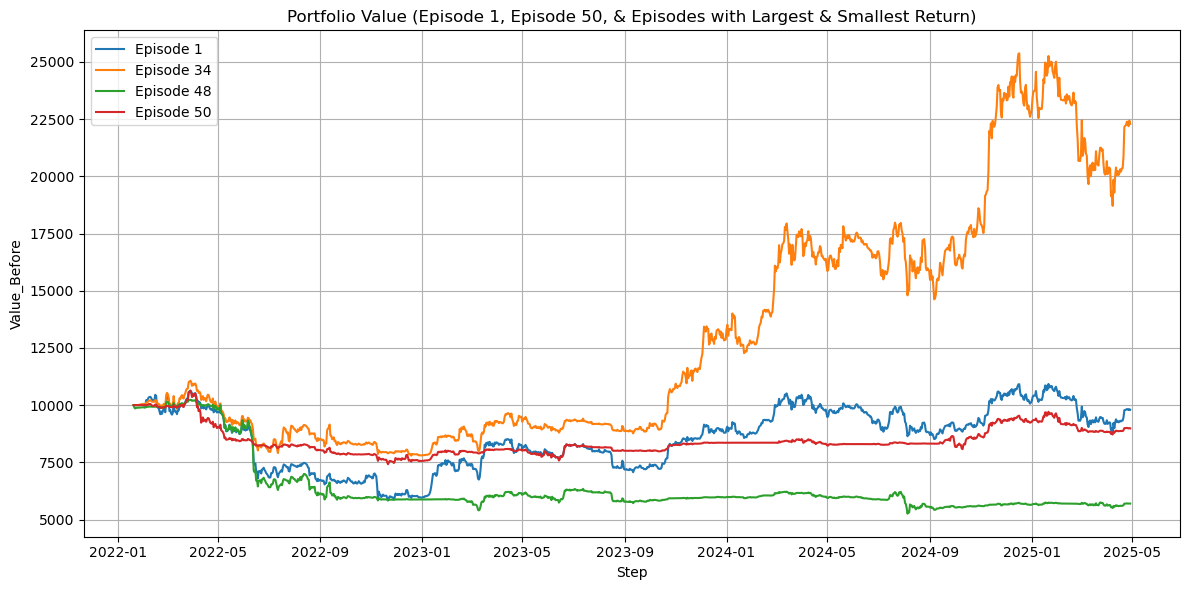

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
title = "Portfolio Value (Episode 1, Episode 50, & Episodes with Largest & Smallest Return)"

for episode in stats_df.head(1)['Episode'].tolist():
    df = results_dict2[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")
    
for episode in stats_df2.head(1)['Episode'].tolist():
    df = results_dict2[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")
    
for episode in stats_df2.tail(1)['Episode'].tolist():
    df = results_dict2[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")

for episode in stats_df.tail(1)['Episode'].tolist():
    df = results_dict2[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")

plt.title(title)
plt.xlabel("Step")
plt.ylabel("Value_Before")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(title, dpi=300, bbox_inches='tight')
plt.show()

In [172]:
import matplotlib.pyplot as plt

def plot_portfolio_cash_inventory(results_df, title):
    """
    Plots Value_Before, Cash, and Inventory over time from the results DataFrame.
    
    Parameters:
    - results_df: DataFrame containing 'Date', 'Value_Before', 'Cash', and 'Inventory'
    """
    plt.figure(figsize=(14, 8))

    # Plot 1: Portfolio Value Before Action
    plt.subplot(3, 1, 1)
    plt.plot(results_df["Date"], results_df["Value_Before"], color='purple')
    plt.title("Portfolio Value Before Action")
    plt.ylabel("Value ($)")
    plt.xticks(rotation=45)
    plt.grid(True)

    # Plot 2: Cash
    plt.subplot(3, 1, 2)
    plt.plot(results_df["Date"], results_df["Cash"], color='green')
    plt.title("Cash Over Time")
    plt.ylabel("Cash ($)")
    plt.xticks(rotation=45)
    plt.grid(True)

    # Plot 3: Inventory
    plt.subplot(3, 1, 3)
    plt.plot(results_df["Date"], results_df["Inventory"], color='blue')
    plt.title("Inventory Over Time")
    plt.ylabel("Coins Held")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()

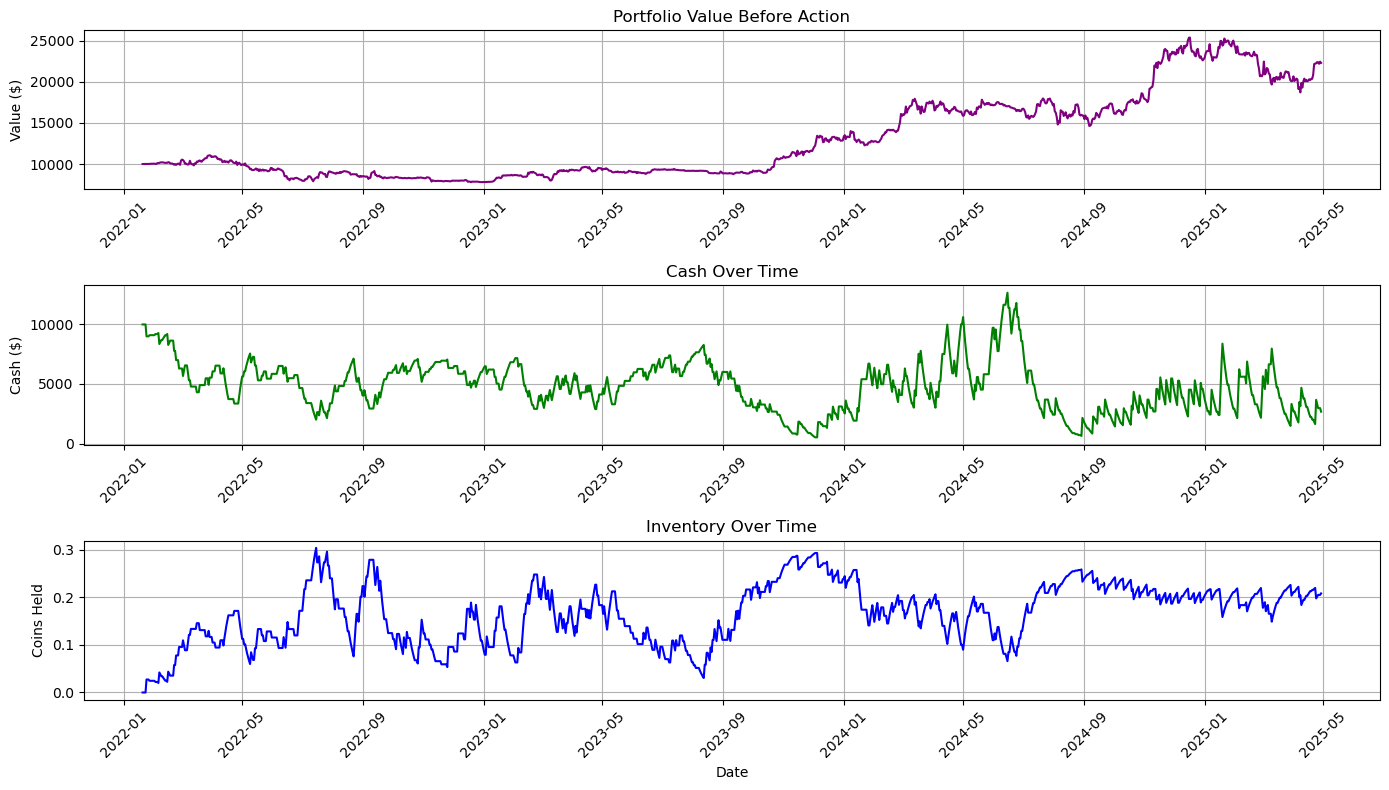

In [174]:
plot_portfolio_cash_inventory(results_dict2[34], "Episode 34")

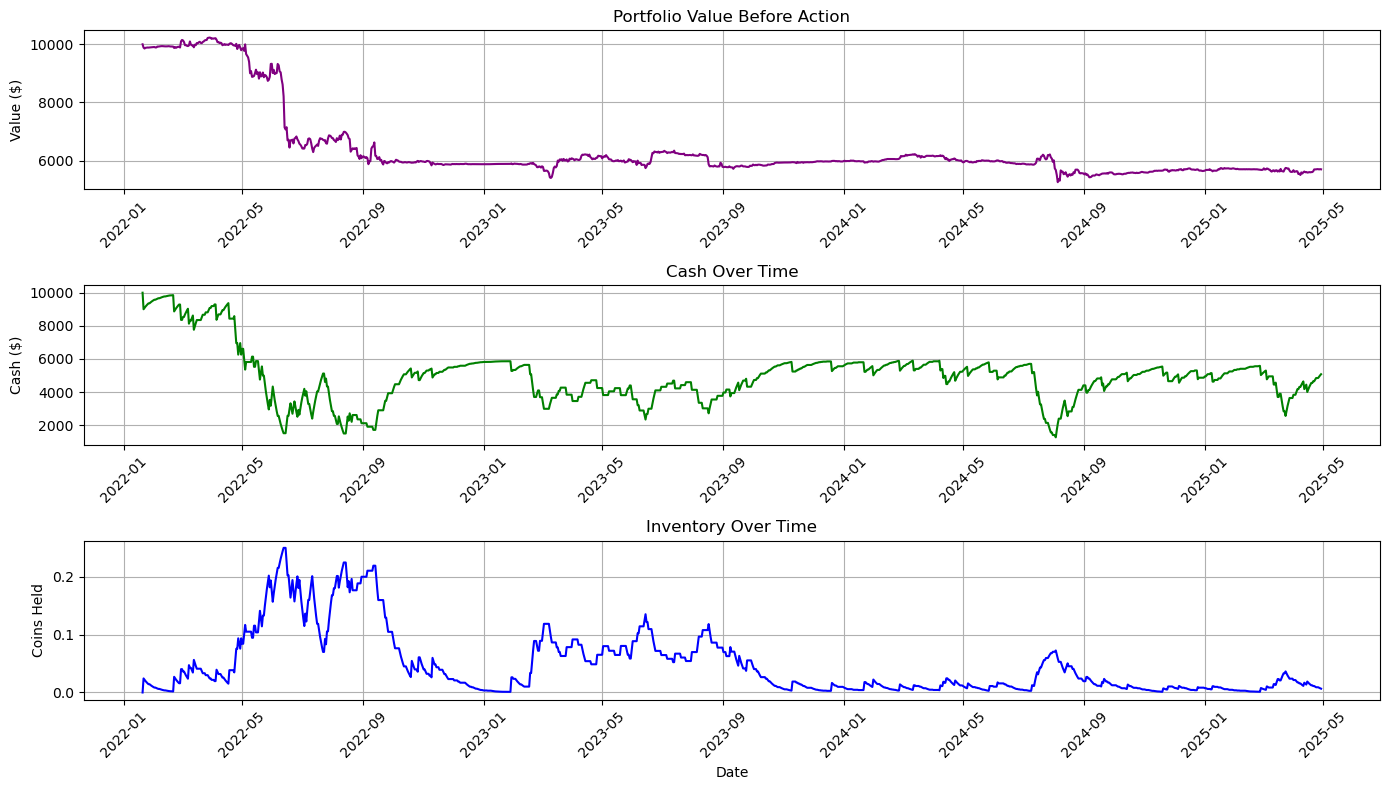

In [175]:
plot_portfolio_cash_inventory(results_dict2[48], "Episode 48")

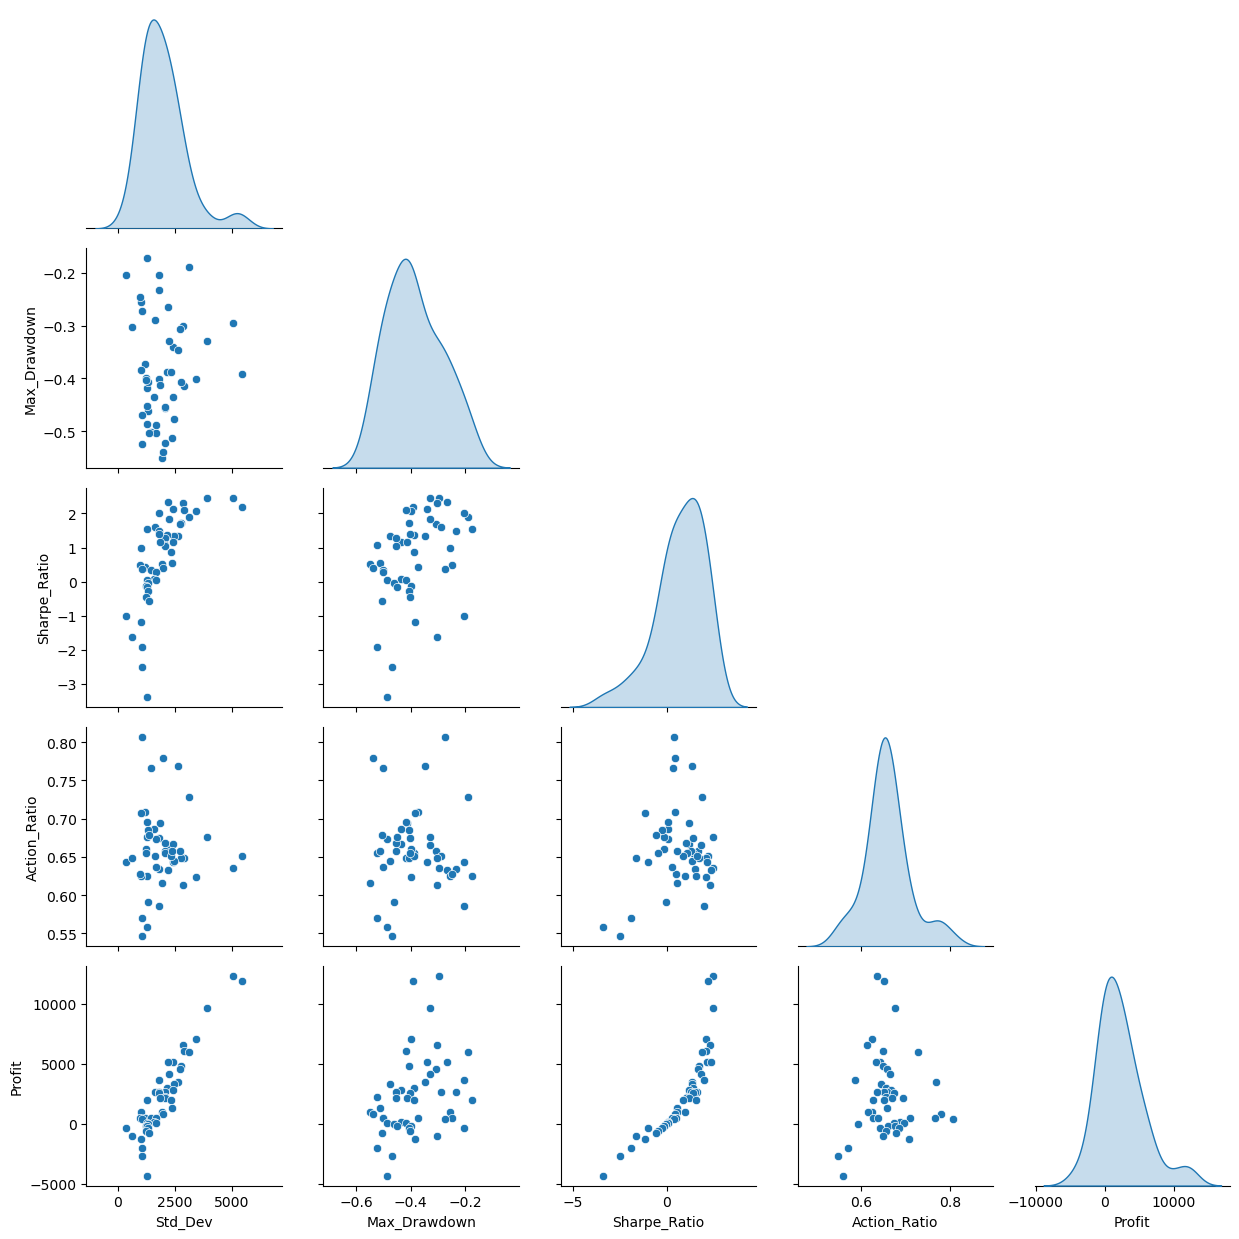

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select just the metrics
metrics_df = stats_df2[["Std_Dev", "Max_Drawdown", "Sharpe_Ratio", "Action_Ratio", "Profit"]]

# Create a pairplot
sns.pairplot(metrics_df, diag_kind="kde", corner=True)
plt.tight_layout()
plt.savefig("Pairwise Metric Relationships", dpi=300, bbox_inches='tight')
plt.show()

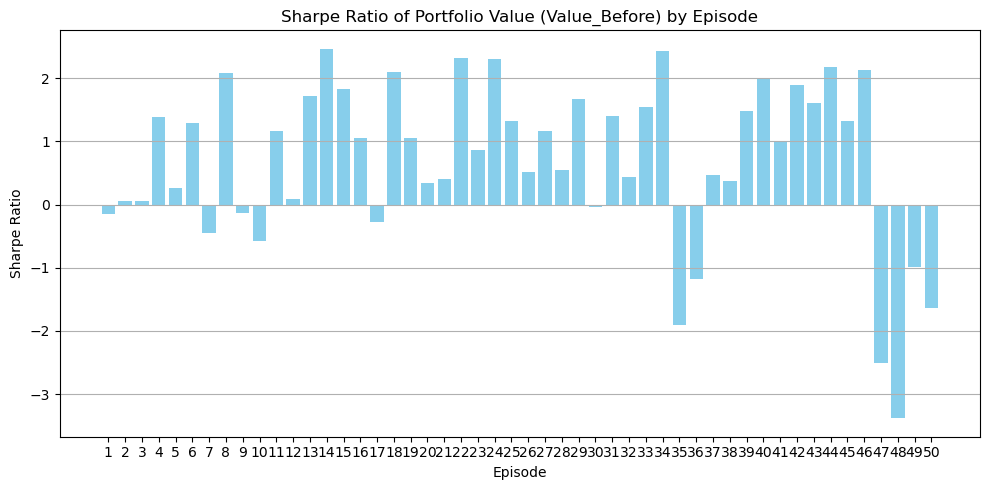

In [177]:
import matplotlib.pyplot as plt

title = "Sharpe Ratio of Portfolio Value (Value_Before) by Episode"

plt.figure(figsize=(10, 5))
plt.bar(stats_df2["Episode"], stats_df2["Sharpe_Ratio"], color='skyblue')
plt.title(title)
plt.xlabel("Episode")
plt.ylabel("Sharpe Ratio")
plt.xticks(stats_df["Episode"])
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(title, dpi=300, bbox_inches='tight')
plt.show()

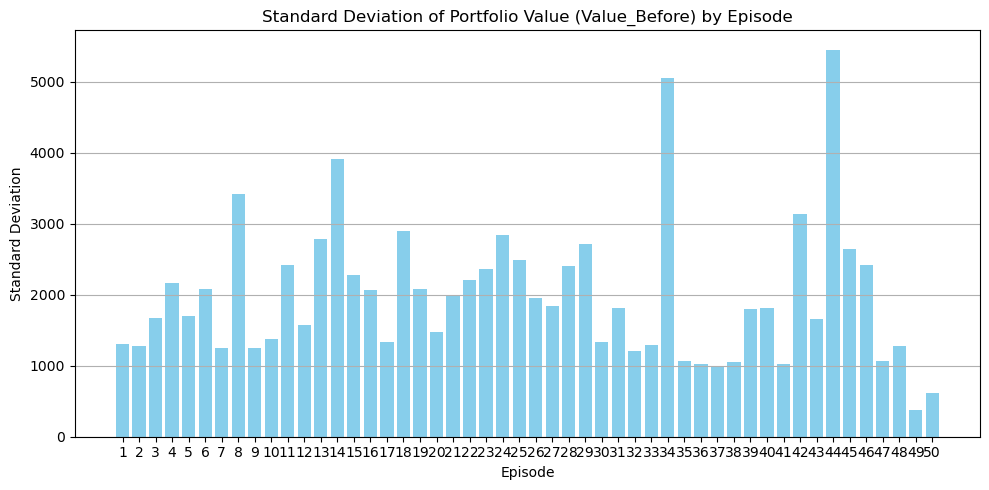

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(stats_df["Episode"], stats_df["Std_Dev"], color='skyblue')
plt.title("Standard Deviation of Portfolio Value (Value_Before) by Episode")
plt.xlabel("Episode")
plt.ylabel("Standard Deviation")
plt.xticks(stats_df["Episode"])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [179]:
import matplotlib.pyplot as plt

def plot_stat_by_episode(stats_df, stat, title):
    """
    Plots the given statistic (column) by episode.

    Parameters:
    - stats_df: DataFrame containing the data (must include 'Episode' and the specified stat)
    - stat: string, name of the column to plot (e.g., 'Std_Dev', 'Sharpe_Ratio')
    - title: string, title of the plot (also used as filename when saving)
    """
    plt.figure(figsize=(10, 5))
    plt.bar(stats_df["Episode"], stats_df[stat], color='skyblue')
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(stat.replace('_', ' '))
    plt.xticks(stats_df["Episode"], rotation=90)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')
    plt.show()

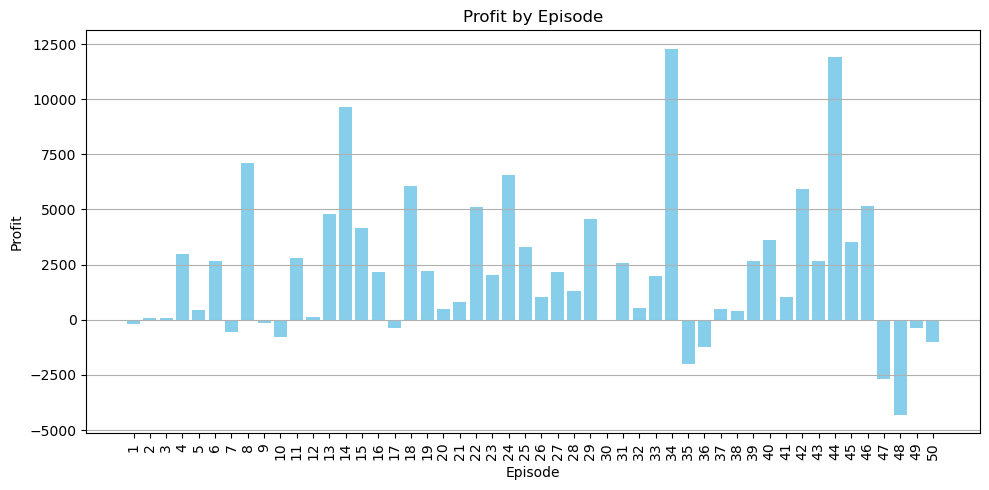

In [180]:
plot_stat_by_episode(stats_df, "Profit", "Profit by Episode")

In [142]:
actions = ['buy_1', 'buy_2', 'hold', 'sell_1', 'sell_2']
q_table = Q_table(actions, num_signals=4)
q_table.q_table

buy_1  buy_2  hold  sell_1  sell_2
signal_1 signal_2 signal_3 signal_4                                    
-1       -1       -1       -1          0.0    0.0   0.0     0.0     0.0
                            0          0.0    0.0   0.0     0.0     0.0
                            1          0.0    0.0   0.0     0.0     0.0
                   0       -1          0.0    0.0   0.0     0.0     0.0
                            0          0.0    0.0   0.0     0.0     0.0
...                                    ...    ...   ...     ...     ...
 1        1        0        0          0.0    0.0   0.0     0.0     0.0
                            1          0.0    0.0   0.0     0.0     0.0
                   1       -1          0.0    0.0   0.0     0.0     0.0
                            0          0.0    0.0   0.0     0.0     0.0
                            1          0.0    0.0   0.0     0.0     0.0

[81 rows x 5 columns]

# Task 2 (Buy or Sell 0.20 Cash or Inventory per Transaction)

In [200]:
def train_multiple_episodes(price_df, episodes=2):
    """
    Run SARSA training over multiple episodes using the same price data.

    Returns:
    - q_table: trained Q_table object
    - agent: trained Agent object
    - results_dict: dictionary of {episode_number: DataFrame of logs}
    """
    actions = ['buy', 'hold', 'sell']
    agent = Agent(actions)
    q_table = Q_table(actions, num_signals=4)

    results_dict = {}

    for ep in range(1, episodes + 1):
        portfolio = Portfolio(
        price_df=price_df,
        initial_cash=10000,
        initial_inventory=0,
        transaction_size=0.2  # trade 20% per action
    )

        # Logging containers for current episode
        date_log = []
        state_log = []
        action_log = []
        reward_log = []
        value_before_log = []
        value_after_log = []
        price_log = []
        cash_log = []
        inventory_log = []

        # Initial state and action
        state = portfolio.get_state()
        action = agent.get_action(
            state, q_table,
            portfolio.action_repeat_count,
            portfolio.max_repeat
        )

        while portfolio.current_step < len(portfolio.price_df) - 1:
            # Log before action
            date_log.append(portfolio.price_df.iloc[portfolio.current_step]['Date'])
            value_before = portfolio.compute_portfolio_value()
            value_before_log.append(value_before)
            state_log.append(state)
            action_log.append(action)
            price_log.append(portfolio.get_curr_price())
            cash_log.append(portfolio.cash)
            inventory_log.append(portfolio.inventory)

            # Take action
            portfolio.take_action(action)

            # Portfolio value after action
            value_after = portfolio.compute_portfolio_value()
            value_after_log.append(value_after)

            # Advance time
            portfolio.current_step += 1

            # Reward = next day's portfolio delta
            value_next = portfolio.compute_portfolio_value()

            reward = value_next - value_after
            
            # Penalize losses, ignore gains
            # reward = min(0, value_next - value_after)
            reward_log.append(reward)

            # Get next state and action
            next_state = portfolio.get_state()
            next_action = agent.get_action(
                next_state, q_table,
                portfolio.action_repeat_count,
                portfolio.max_repeat
            )

            # Update Q-table (SARSA)
            q_table.update(state, action, reward, next_state, next_action)

            # Prepare for next iteration
            state = next_state
            action = next_action

        # Decay exploration rate
        agent.decay_epsilon()

        # Store this episode’s results in a DataFrame
        episode_df = pd.DataFrame({
            "Date": date_log,
            "State": state_log,
            "Action": action_log,
            "Reward": reward_log,
            "Value_Before": value_before_log,
            "Value_After": value_after_log,
            "Price": price_log,
            "Cash": cash_log,
            "Inventory": inventory_log
        })

        results_dict[ep] = episode_df

    return q_table, agent, results_dict

In [201]:
q_table7, agent7, results_dict7 = train_multiple_episodes(df3, episodes=50)

In [202]:
results_dict7[1]

,Date,State,Action,Reward,Value_Before,Value_After,Price,Cash,Inventory
0,2022-01-20,"(0, 0, 0, 0)",buy,-205.547079,10000.000000,9980.000000,40680.417969,10000.000000,0.000000
1,2022-01-21,"(0, 0, 0, -1)",buy,-131.461550,9774.452921,9758.452921,36457.316406,8000.000000,0.048672
2,2022-01-22,"(0, 0, 0, -1)",buy,159.926216,9626.991370,9614.191370,35030.250000,6400.000000,0.092120
3,2022-01-23,"(0, 0, 0, 0)",hold,48.434213,9774.117586,9774.117586,36276.804688,5120.000000,0.128295
4,2022-01-24,"(0, 0, 0, 0)",hold,38.446780,9822.551799,9822.551799,36654.328125,5120.000000,0.128295
...,...,...,...,...,...,...,...,...,...
1191,2025-04-25,"(-1, 0, 0, 0)",buy,-3.453090,6703.747454,6698.116647,94720.500000,2815.403785,0.041051
1192,2025-04-26,"(1, 0, 0, 0)",hold,-41.870872,6694.663557,6694.663557,94646.929688,2252.323028,0.046936
1193,2025-04-27,"(1, 0, 0, 0)",sell,45.956131,6652.792684,6643.991745,93754.843750,2252.323028,0.046936
1194,2025-04-28,"(-1, 0, 0, 0)",hold,-26.057355,6689.947876,6689.947876,94978.750000,3123.616020,0.037549


In [203]:
stats_df7 = evaluate_episode_stability(results_dict7)
display(stats_df7.head())
display(stats_df7.tail())

,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
0,1,1288.108432,-0.530450,-2.589929,0.673077,-3336.109479
1,2,1404.480751,-0.560024,-2.653009,0.663043,-3726.100659
2,3,1178.622815,-0.540595,-3.425482,0.672241,-4037.350964
3,4,1170.550177,-0.497277,-2.278358,0.638796,-2666.932222
4,5,1151.261636,-0.427359,-0.819096,0.689799,-942.993682


,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
45,46,993.574873,-0.457346,-3.202905,0.826923,-3182.325538
46,47,712.631664,-0.305312,-2.157132,0.780100,-1537.240654
47,48,736.798863,-0.330421,-3.992692,0.759197,-2941.810968
48,49,1215.268237,-0.305457,-0.409394,0.697324,-497.523257
49,50,595.767375,-0.234483,-1.699292,0.646321,-1012.382492


In [204]:
stats_df7 = stats_df7.sort_values(by=["Sharpe_Ratio"], ascending=False)
display(stats_df7.head(3))
display(stats_df7.tail(3))

,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
28,29,2686.418366,-0.383033,1.465301,0.654682,3936.411653
25,26,2884.491103,-0.513786,1.185276,0.549331,3418.918151
39,40,2143.420153,-0.408197,1.167565,0.568562,2502.581820


,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
27,28,1234.633800,-0.537177,-3.775420,0.805184,-4661.261471
35,36,697.143290,-0.309164,-3.867987,0.727425,-2696.540976
47,48,736.798863,-0.330421,-3.992692,0.759197,-2941.810968


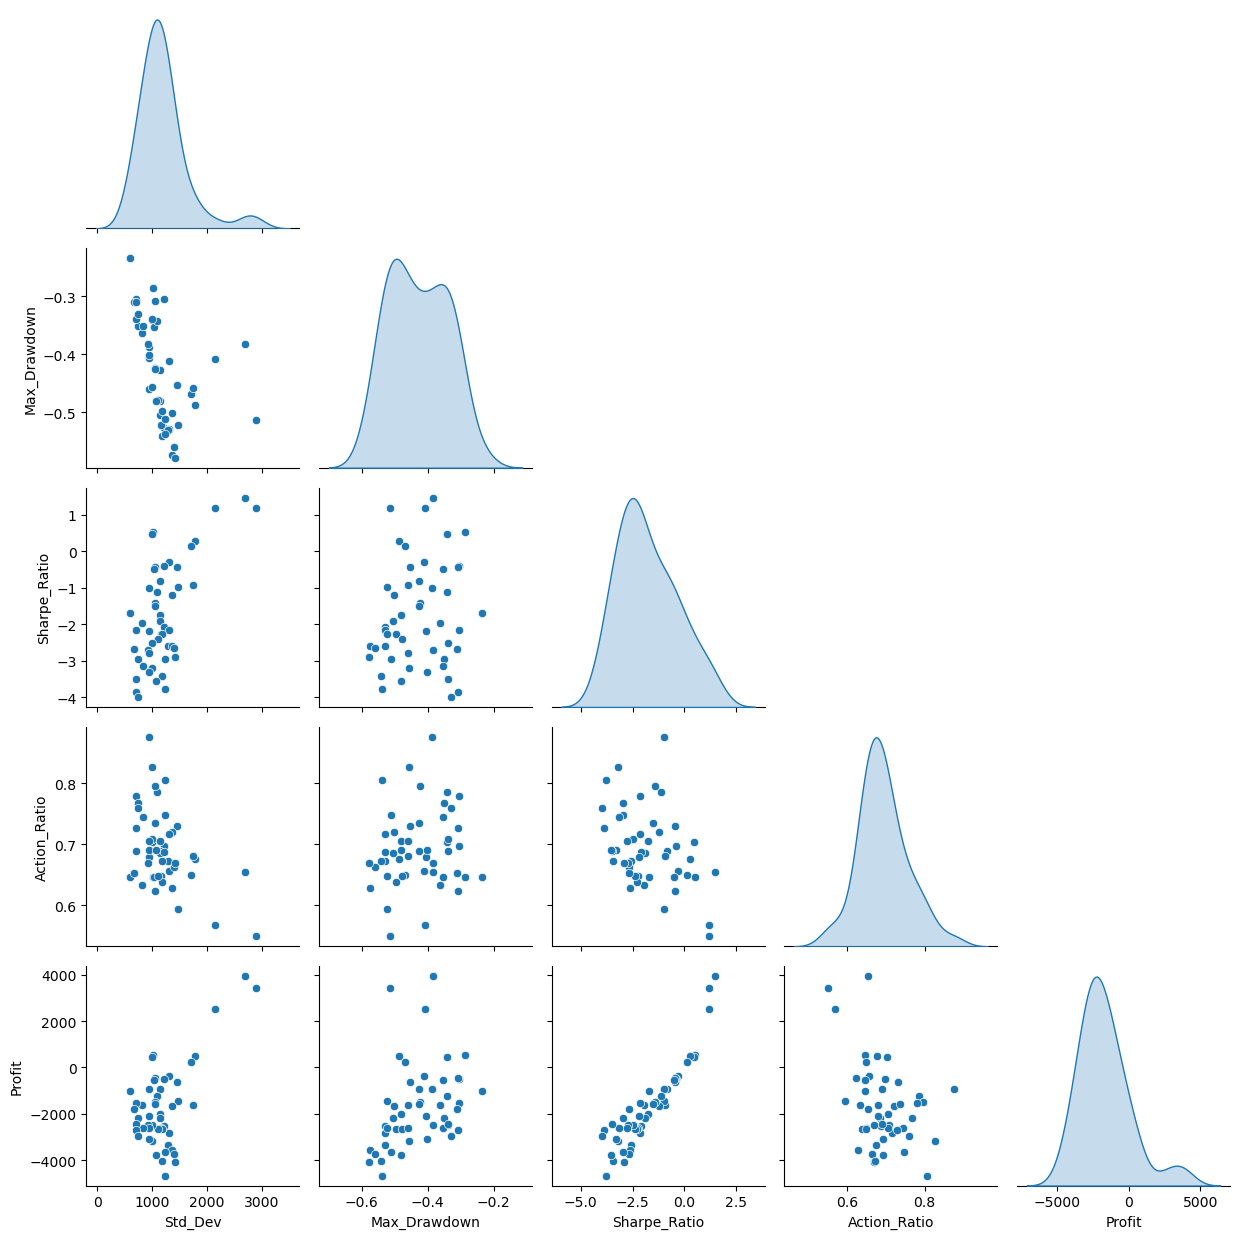

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select just the metrics
metrics_df = stats_df7[["Std_Dev", "Max_Drawdown", "Sharpe_Ratio", "Action_Ratio", "Profit"]]

# Create a pairplot
sns.pairplot(metrics_df, diag_kind="kde", corner=True)
plt.tight_layout()
plt.savefig("Pairwise Metric Relationships", dpi=300, bbox_inches='tight')
plt.show()

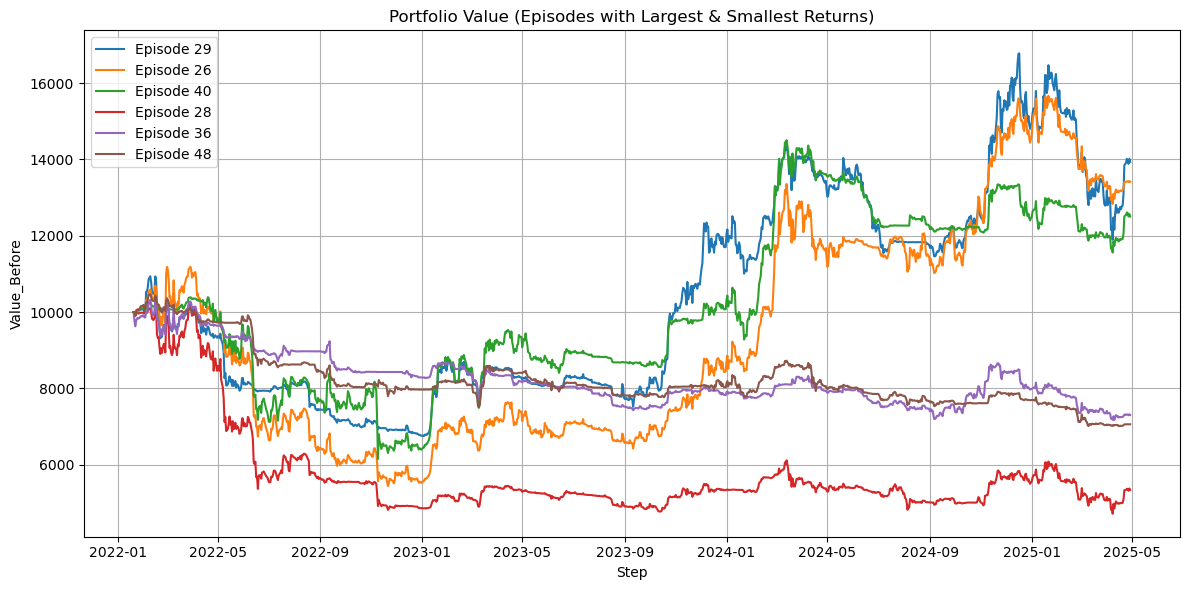

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
title = "Portfolio Value (Episodes with Largest & Smallest Returns)"

for episode in stats_df7.head(3)['Episode'].tolist():
    df = results_dict7[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")

for episode in stats_df7.tail(3)['Episode'].tolist():
    df = results_dict7[episode]
    plt.plot(df['Date'], df["Value_Before"].values, label=f"Episode {episode}")

plt.title(title)
plt.xlabel("Step")
plt.ylabel("Value_Before")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(title, dpi=300, bbox_inches='tight')
plt.show()

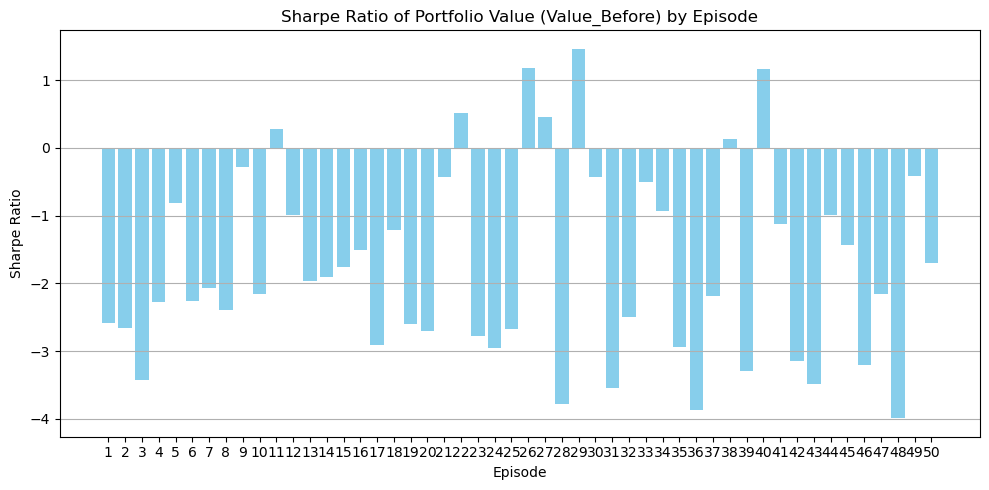

In [207]:
import matplotlib.pyplot as plt

title = "Sharpe Ratio of Portfolio Value (Value_Before) by Episode"

plt.figure(figsize=(10, 5))
plt.bar(stats_df7["Episode"], stats_df7["Sharpe_Ratio"], color='skyblue')
plt.title(title)
plt.xlabel("Episode")
plt.ylabel("Sharpe Ratio")
plt.xticks(stats_df["Episode"])
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(title, dpi=300, bbox_inches='tight')
plt.show()

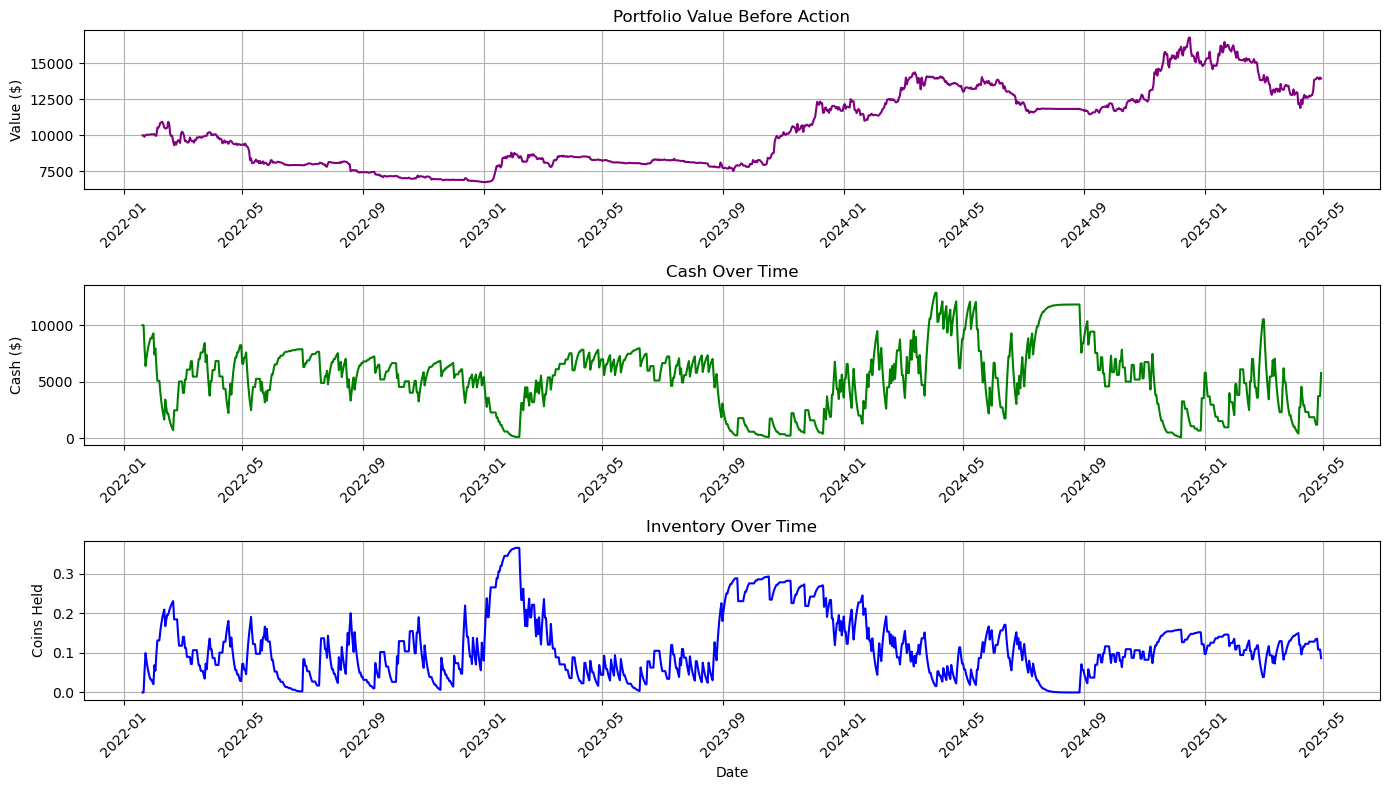

In [209]:
plot_portfolio_cash_inventory(results_dict7[29], "Trading With 1 or 2 Coins")

In [211]:
print("\n=== Q_table: Non-zero Q-value States ===")
non_zero_q = q_table7.q_table[(q_table7.q_table != 0).any(axis=1)]
display(non_zero_q)


=== Q_table: Non-zero Q-value States ===


buy        hold       sell
signal_1 signal_2 signal_3 signal_4                                   
-1       -1       0         0         24.877710   45.950266  13.575180
          0       0        -1       -133.836252 -126.720049 -30.690014
                            0         79.559702  -19.620806   2.112107
                            1         19.076235    1.623433  34.660122
          1       0         0         19.360437   13.016694  15.440848
                            1        -63.796594   -5.200844 -49.336143
 0        0       0        -1         50.937571    2.667397  23.689607
                            0         15.332554   31.552549  36.211709
 1       -1       0        -1         22.271942    8.720210 -25.514731
                            0          2.000907   48.081778  11.524215
          0       0        -1        -25.977533   31.781400 -72.241500
                            0        -24.735110   -4.427402  22.965920
                            1        108.838313   87.119288  89.708325
          1       0         0        -20.087077  -32.129888   0.146277

In [215]:
def train_with_greedy_policy(price_df, q_table, agent):
    """
    Run an evaluation loop using a trained Q-table with greedy policy (no exploration).
    
    Returns:
    - portfolio, results (DataFrame with per-step logs)
    """
    portfolio = Portfolio(price_df)
    actions = agent.actions  # Assumes trained agent has actions defined

    # Record containers
    date_log = []
    state_log = []
    action_log = []
    reward_log = []
    value_before_log = []
    value_after_log = []
    price_log = []
    cash_log = []
    inventory_log = []

    # Initial state
    state = portfolio.get_state()

    # Choose greedy action from Q-table
    q_values = q_table.q_table.loc[state]
    valid_actions = [a for a in actions if portfolio.action_repeat_count.get(a, 0) < portfolio.max_repeat]
    action = max(valid_actions, key=lambda a: q_values[a]) if valid_actions else 'hold'

    while portfolio.current_step < len(portfolio.price_df) - 1:
        # Log before action
        date_log.append(portfolio.price_df.iloc[portfolio.current_step]['Date'])
        value_before = portfolio.compute_portfolio_value()
        value_before_log.append(value_before)
        state_log.append(state)
        action_log.append(action)
        price_log.append(portfolio.get_curr_price())
        cash_log.append(portfolio.cash)
        inventory_log.append(portfolio.inventory)

        # Take action
        portfolio.take_action(action)

        # Compute value after action
        value_after = portfolio.compute_portfolio_value()
        value_after_log.append(value_after)

        # Advance one step
        portfolio.current_step += 1

        # Compute reward
        value_next = portfolio.compute_portfolio_value()
        reward = value_next - value_after
        reward_log.append(reward)

        # Get next state
        next_state = portfolio.get_state()

        # Choose next greedy action from Q-table
        q_values = q_table.q_table.loc[next_state]
        valid_actions = [a for a in actions if portfolio.action_repeat_count.get(a, 0) < portfolio.max_repeat]
        next_action = max(valid_actions, key=lambda a: q_values[a]) if valid_actions else 'hold'

        # Prepare for next step
        state = next_state
        action = next_action

    # Combine logs into a results DataFrame
    results = pd.DataFrame({
        "Date": date_log,
        "State": state_log,
        "Action": action_log,
        "Reward": reward_log,
        "Value_Before": value_before_log,
        "Value_After": value_after_log,
        "Price": price_log,
        "Cash": cash_log,
        "Inventory": inventory_log
    })

    return portfolio, results

In [216]:
results_dict8 = {}
portfolio_eval, results_dict8['Task 1'] = train_with_greedy_policy(df3, q_table2, agent2)

In [219]:
def train_with_greedy_policy2(price_df, q_table, agent):
    """
    Run an evaluation loop using a trained Q-table with greedy policy (no exploration).
    
    Returns:
    - portfolio, results (DataFrame with per-step logs)
    """
    portfolio = Portfolio(
        price_df=price_df,
        initial_cash=10000,
        initial_inventory=0,
        transaction_size=0.2  # trade 20% per action
    )
    actions = agent.actions  # Assumes trained agent has actions defined

    # Record containers
    date_log = []
    state_log = []
    action_log = []
    reward_log = []
    value_before_log = []
    value_after_log = []
    price_log = []
    cash_log = []
    inventory_log = []

    # Initial state
    state = portfolio.get_state()

    # Choose greedy action from Q-table
    q_values = q_table.q_table.loc[state]
    valid_actions = [a for a in actions if portfolio.action_repeat_count.get(a, 0) < portfolio.max_repeat]
    action = max(valid_actions, key=lambda a: q_values[a]) if valid_actions else 'hold'

    while portfolio.current_step < len(portfolio.price_df) - 1:
        # Log before action
        date_log.append(portfolio.price_df.iloc[portfolio.current_step]['Date'])
        value_before = portfolio.compute_portfolio_value()
        value_before_log.append(value_before)
        state_log.append(state)
        action_log.append(action)
        price_log.append(portfolio.get_curr_price())
        cash_log.append(portfolio.cash)
        inventory_log.append(portfolio.inventory)

        # Take action
        portfolio.take_action(action)

        # Compute value after action
        value_after = portfolio.compute_portfolio_value()
        value_after_log.append(value_after)

        # Advance one step
        portfolio.current_step += 1

        # Compute reward
        value_next = portfolio.compute_portfolio_value()
        reward = value_next - value_after
        reward_log.append(reward)

        # Get next state
        next_state = portfolio.get_state()

        # Choose next greedy action from Q-table
        q_values = q_table.q_table.loc[next_state]
        valid_actions = [a for a in actions if portfolio.action_repeat_count.get(a, 0) < portfolio.max_repeat]
        next_action = max(valid_actions, key=lambda a: q_values[a]) if valid_actions else 'hold'

        # Prepare for next step
        state = next_state
        action = next_action

    # Combine logs into a results DataFrame
    results = pd.DataFrame({
        "Date": date_log,
        "State": state_log,
        "Action": action_log,
        "Reward": reward_log,
        "Value_Before": value_before_log,
        "Value_After": value_after_log,
        "Price": price_log,
        "Cash": cash_log,
        "Inventory": inventory_log
    })

    return portfolio, results

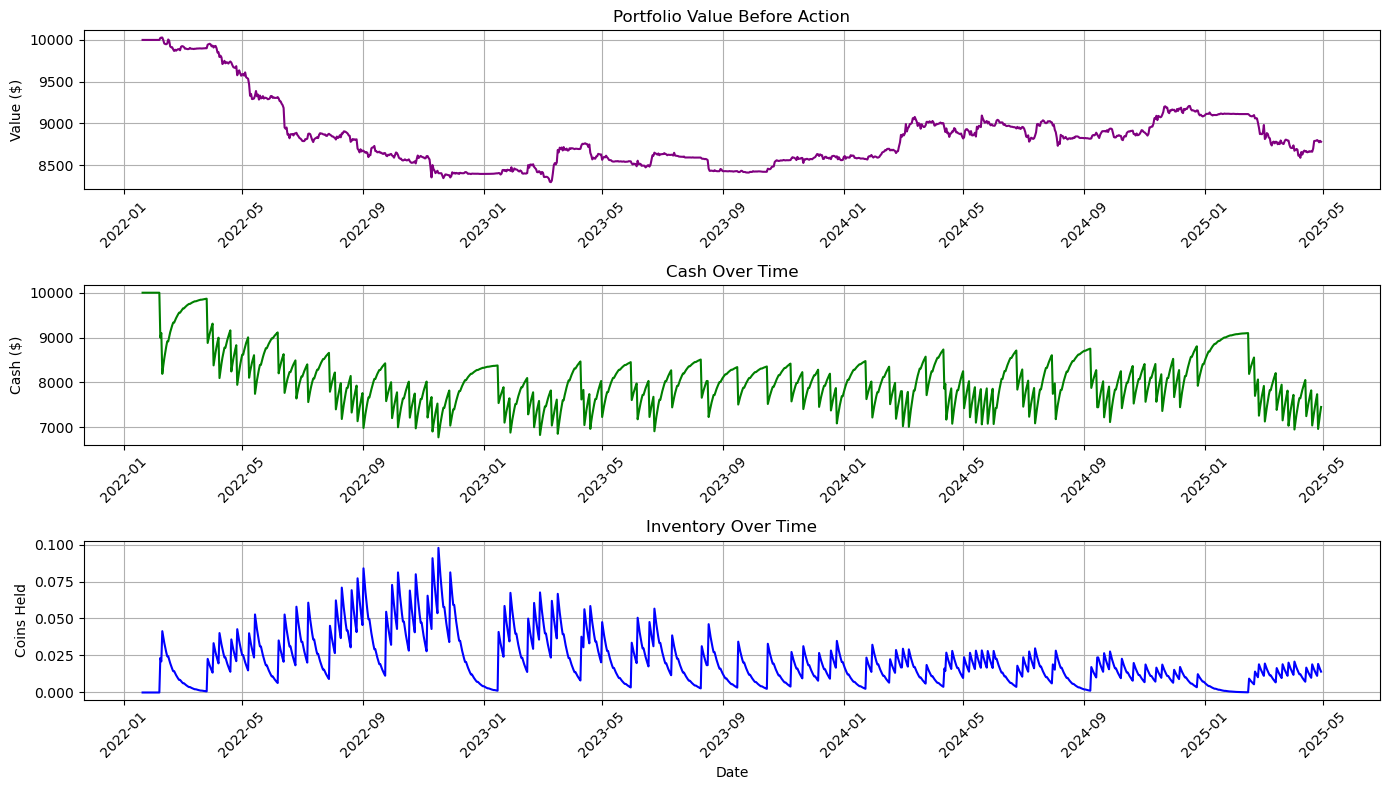

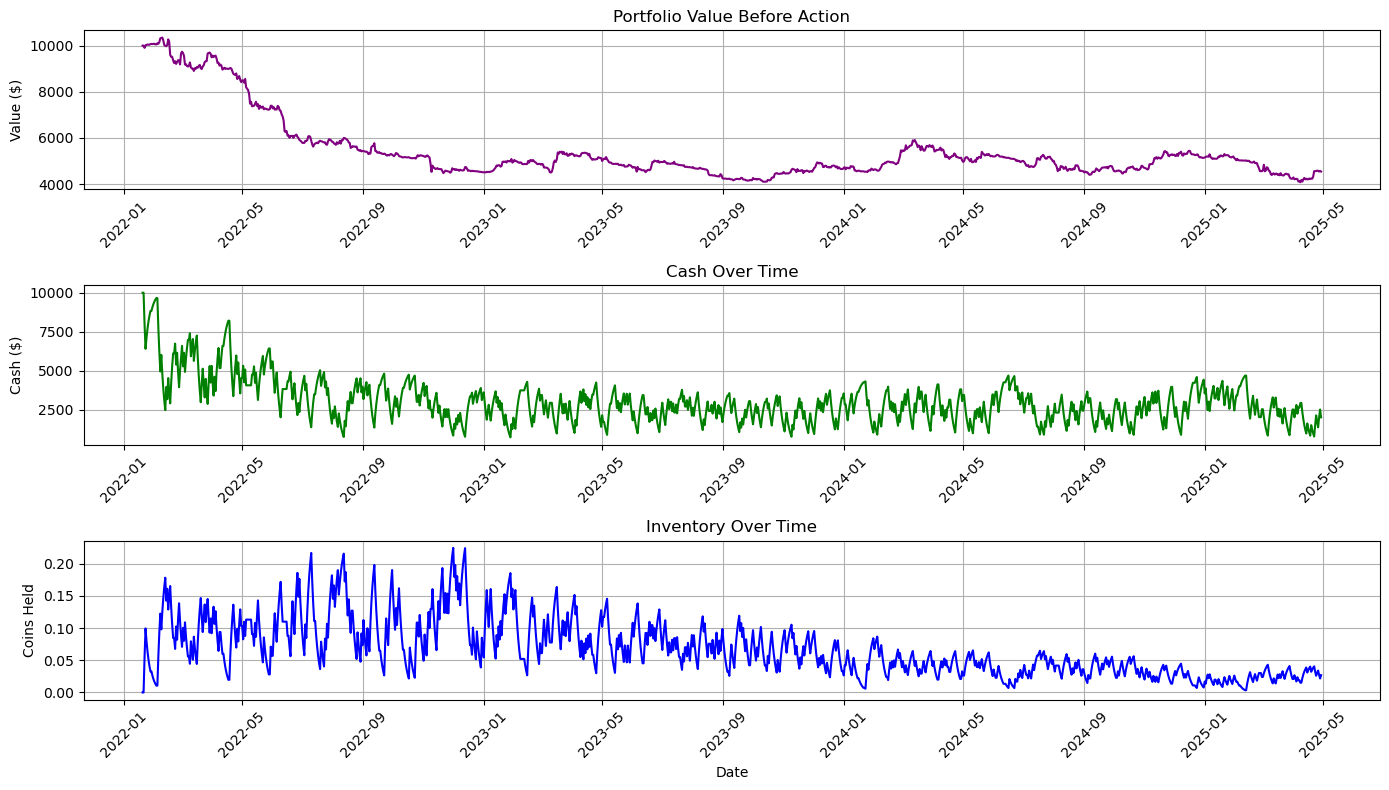

,Episode,Std_Dev,Max_Drawdown,Sharpe_Ratio,Action_Ratio,Profit
0,Task 1,399.041924,-0.172571,-3.053708,0.908863,-1218.557435
1,Task 2,1382.895450,-0.605593,-3.946262,0.927258,-5457.268430


In [220]:
portfolio_eval, results_dict8['Task 2'] = train_with_greedy_policy2(df3, q_table7, agent7)

plot_portfolio_cash_inventory(results_dict8['Task 1'], "Training Result For Task 1")
plot_portfolio_cash_inventory(results_dict8['Task 2'], "Training Result For Task 2")

stats_df8 = evaluate_episode_stability(results_dict8)
display(stats_df8)